# BVG Crew Scheduling -- TTN Fraction Sweep (Simulator Benchmark - Final Submission)

**Pipeline:** `QUBO(N) -> TTN(fraction*N) -> Krylov(35% of TTN) -> Miray -> Krylov expand -> TTN expand -> Assignments`

---

## TTN Fraction Sweep

Benchmarks **9 TTN fractions** on simulator to find the optimal TTN reduction:

| # | Fraction | Backend | Description |
| - | -------- | ------- | ----------- |
| 1 | 30% | `ibm_aer_mps` | Aggressive reduction — keeps only 30% of variables |
| 2 | 40% | `ibm_aer_mps` | |
| 3 | 50% | `ibm_aer_mps` | |
| 4 | 55% | `ibm_aer_mps` | |
| 5 | 60% | `ibm_aer_mps` | |
| 6 | 70% | `ibm_aer_mps` | |
| 7 | 80% | `ibm_aer_mps` | |
| 8 | 90% | `ibm_aer_mps` | Light reduction |
| 9 | 100% | `ibm_aer_mps` | No TTN (Krylov only baseline) |

**Parameters:** KRYLOV_FRACTION=0.35, LANCZOS=8, SHOTS=100, MAX_META_ROUTES=6, TN_SWEEPS=5
**Pre-expansion:** CVaR filtering and probabilistic bit flipping (implemented, **disabled** for this benchmark)
**Hardware:** Disabled (toggle `ENABLE_HARDWARE = True` to add IBM Fez runs)

# BVG Crew Scheduling — Quantum Optimization Tutorial

## Team Beerantum | Berlin Quantum Hackathon 2026

---

### What This Notebook Does

Berlin's BVG public transit system needs to assign **bus drivers** to **rotation segments**
(individual trips like "drive the M29 from Zoo to Hermannplatz at 07:15"). This is a
**combinatorial optimization problem**: with hundreds of segments and dozens of drivers,
the number of possible assignments is astronomical.

We solve this using **quantum computing** by encoding the assignment problem as a
**QUBO** (Quadratic Unconstrained Binary Optimization) and sending it to a quantum solver.

### The Problem With Going Directly to Quantum

Current quantum hardware can only handle ~20-50 variables reliably. But 200 segments
x 3 drivers = **600 variables** — way too many. So we use a **3-level decomposition** to
break the problem into small pieces, plus **compression techniques** to shrink each piece further.

### The 2 Benchmark Configurations

| # | Label | Backend | Compression |
|---|-------|---------|-------------|
| 1 | TTN-Krylov_Simulator | `ibm_aer_mps` | TTN+Krylov (TTN selects first, Krylov projects second) |
| 2 | TTN-Krylov_Hardware | `ibm_fez` | TTN+Krylov (TTN selects first, Krylov projects second) |

---

## Cell 0a — Install Dependencies

Before we can do anything, we need to install the Python libraries this notebook uses.
If you're running on Google Colab, these aren't pre-installed.

Here's what each package does:

- **`pandas`** — reads Excel files and works with tabular data (our BVG dataset is an `.xlsx`)
- **`openpyxl`** — the engine pandas uses under the hood to read/write Excel files
- **`numpy`** — numerical arrays and linear algebra (used for QUBO matrices)
- **`scipy`** — scientific computing (we use sparse matrices and eigenvalue solvers for Krylov)
- **`scikit-learn`** — machine learning library (we use its clustering algorithms to group segments)
- **`qiskit`** — IBM's quantum computing framework (we use it to formulate the QUBO)
- **`qiskit-optimization`** — Qiskit's optimization module (converts constraints into QUBO form)
- **`planqk-service-sdk`** — the PlanQK platform client (sends our QUBO to the Miray quantum solver)
- **`matplotlib`** — plotting library for visualizations

Run this cell once. You'll see some output as pip downloads and installs each package.


In [ ]:
!pip install pandas openpyxl numpy scipy scikit-learn qiskit qiskit-optimization planqk-service-sdk matplotlib

---

## Cell 0b — Upload the BVG Dataset

Google Colab doesn't save files between sessions, so you need to upload the dataset
every time you open this notebook.

The file is called **`BVG Challenge dataset.xlsx`** and contains 3 sheets:

1. **Block Segment** — every bus trip segment (route, times, locations)
2. **Travel Time** — how long it takes to drive between any two depots/stops
3. **Driver Preference** — what each driver prefers (lines, shifts, depots)

**What the code below does, line by line:**

```python
from google.colab import files      # Colab's built-in file upload widget
uploaded = files.upload()            # Opens a file picker — select BVG Challenge dataset.xlsx
print(f"Uploaded: {list(uploaded.keys())}")  # Confirms which files were uploaded
```

If you're running locally (not Colab), just make sure the file is in the same folder.


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║          UPLOAD DATASET — Required at the start of each Colab session   ║
# ╚══════════════════════════════════════════════════════════════════════════╝

import os

DATASET_FILENAME = 'BVG Challenge dataset.xlsx'

# Auto-detect environment
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# --- Google Drive for persistent Colab storage ---
DRIVE_RESULTS = None
if IN_COLAB:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        DRIVE_RESULTS = Path('/content/drive/MyDrive/BVG_Results')
        DRIVE_RESULTS.mkdir(parents=True, exist_ok=True)
        print(f'Google Drive mounted. Results also saved to: {DRIVE_RESULTS}')
    except Exception as e:
        print(f'Drive mount skipped (optional): {e}')


if IN_COLAB:
    if not os.path.exists(DATASET_FILENAME):
        from google.colab import files
        print(f"📂 Please upload '{DATASET_FILENAME}'...")
        uploaded = files.upload()
        if DATASET_FILENAME not in uploaded:
            # Handle case where user uploaded with slightly different name
            for name in uploaded:
                if name.endswith('.xlsx'):
                    os.rename(name, DATASET_FILENAME)
                    print(f"  Renamed '{name}' → '{DATASET_FILENAME}'")
                    break
        print(f"✅ Dataset uploaded: {DATASET_FILENAME} ({os.path.getsize(DATASET_FILENAME)/1024:.0f} KB)")
    else:
        print(f"✅ Dataset already present: {DATASET_FILENAME} ({os.path.getsize(DATASET_FILENAME)/1024:.0f} KB)")
else:
    if os.path.exists(DATASET_FILENAME):
        print(f"✅ Dataset found locally: {DATASET_FILENAME} ({os.path.getsize(DATASET_FILENAME)/1024:.0f} KB)")
    else:
        print(f"⚠️  '{DATASET_FILENAME}' not found in current directory!")
        print(f"   Place the file here: {os.getcwd()}/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted. Results also saved to: /content/drive/MyDrive/BVG_Results
✅ Dataset already present: BVG Challenge dataset.xlsx (7177 KB)


---

## Cell 1 — Import All Required Libraries

This cell loads every library we'll use throughout the notebook. Here's what each line does:

```python
import pandas as pd                  # 'pd' is the standard alias. Gives us DataFrames.
import numpy as np                   # 'np' is standard. Gives us arrays, linear algebra.
import time                          # Measures wall-clock time for benchmarking.
from pathlib import Path             # Creates file paths (e.g., results/output.xlsx).
from typing import List, Dict, ...   # Type hints — makes function signatures readable.
from dataclasses import dataclass, field  # Python's built-in way to define data structures.
from datetime import datetime, timedelta  # Date/time handling (not heavily used here).
from collections import defaultdict  # A dict that auto-creates missing keys.
```

**Quantum/optimization imports:**

```python
from qiskit_optimization import QuadraticProgram      # Defines optimization problems.
from qiskit_optimization.converters import QuadraticProgramToQubo  # Converts to QUBO form.
from planqk.service.client import PlanqkServiceClient  # Talks to the Miray quantum solver.
```

**Math/ML imports:**

```python
from scipy.sparse import csr_matrix           # Efficient sparse matrix storage.
from scipy.sparse.linalg import eigsh         # Finds eigenvalues (used in Krylov).
from sklearn.cluster import AgglomerativeClustering  # Groups similar segments together.
```

**Plotting:**

```python
import matplotlib.pyplot as plt       # The standard Python plotting library.
import matplotlib.gridspec as gridspec # For complex multi-panel figures.
```


In [ ]:
%matplotlib inline
# --- Data & numerical computing ---
import pandas as pd
import numpy as np
# --- Standard library ---
import time
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass, field
from datetime import datetime, timedelta
from collections import defaultdict

# --- Qiskit (quantum computing SDK) ---
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
# --- PlanQK (Miray hybrid solver API) ---
from planqk.service.client import PlanqkServiceClient

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


# Cell 2: Data Classes

## Overview
Defines two core data structures for the BVG scheduling problem:

### `RotationSegment`
Represents a single bus trip with timing and location data. Each segment stores:
- Trip details (ID, bus line, vehicle block)
- Location (from/to depots)
- Timing (start/end times in minutes from midnight)
- Turnaround requirements

### `DriverPreference`
Stores driver preferences and constraints. Now includes **14 preference types** across 3 categories:
- **Basic**: Preferred lines, depots, shift types, day-off requests, earliest start time
- **Rhythm & Rotation**: Split shift rejection, 1/6 duty rejection, rotation direction, weekly day-off, consecutive rest days
- **Contractual**: Daily/weekly working hours, regular weekday start/end times, regular weekday free days

**Toggle Control:** Phase 3 (contractual) preferences are OFF for single-day runs (Cell 4) and ON for multi-day runs (Cell 16).

**Technical Note:** Uses `field(default_factory=dict)` to create fresh dict/list instances for each driver, preventing shared mutable objects.

In [ ]:
@dataclass
class RotationSegment:
    """Represents a single bus trip segment."""
    segment_id: str
    vehicle_block_id: str
    bus_line: str
    from_location: str
    to_location: str
    start_time: int           # Minutes from midnight
    end_time: int
    duration_min: int
    turnaround_time: int
    eligible_turnaround: int
    calendar_day: str


@dataclass
class DriverPreference:
    """Stores a single driver's preferences (complete with all 9+ preference types)."""
    driver_id: str

    # === Basic Preferences (existing) ===
    preferred_lines: List[str] = field(default_factory=list)        # ['M29', 'M41']
    preferred_shifts: List[str] = field(default_factory=list)       # Legacy
    preferred_depots: List[str] = field(default_factory=list)       # ['Zoo', 'Hermannplatz']
    max_shift_minutes: int = 480
    seniority_rank: int = 0
    raw_preferences: Dict = field(default_factory=dict)

    # === Enhanced Preferences (Phase 1) ===
    preferred_shift_types: List[str] = field(default_factory=list)  # ['Früh', 'Spät', 'Nacht']
    day_off_requests: List[str] = field(default_factory=list)       # ['T01', 'T15']
    earliest_start_time: Optional[int] = None                        # Minutes from midnight

    # === Rhythm & Rotation Preferences (Phase 2) ===
    split_shift_rejection_level: int = 0                             # 0-3 (0=accept, 3=strong reject)
    rejects_one_sixth_duty: bool = False                             # True = reject 1/6 duties
    rotation_direction: str = 'Egal'                                 # 'Egal', 'Gleich', 'Gegen'
    weekly_day_off: Optional[str] = None                             # 'Monday', 'Sunday', etc.
    min_consecutive_days_off: int = 1                                # 1, 2, or 3 days

    # === Contractual & Time Constraints (Phase 3) ===
    daily_working_hours: int = 8                                     # Target daily hours (6, 7, 8, 9)
    weekly_working_hours: int = 40                                   # Contract hours per week (20, 25, 30, 35, 38, 40)
    regular_weekday_start: Dict[str, int] = field(default_factory=dict)  # Mo~So -> earliest start (minutes)
    regular_weekday_end: Dict[str, int] = field(default_factory=dict)    # Mo~So -> latest end (minutes)
    regular_weekday_free: Dict[str, bool] = field(default_factory=dict)  # Mo~So -> is free day


print("✓ Data classes defined (with Phase 1-3 preferences)")

✓ Data classes defined (with Phase 1-3 preferences)


# Cell 3: BVG Data Loader

## Overview
Loads and preprocesses all BVG dataset sheets from Excel, converting raw data into `RotationSegment` and `DriverPreference` objects.

## Key Methods

**`time_to_minutes()`** — Normalizes various time formats (`'7h15'`, `'07:15'`, `Timedelta`) to minutes from midnight (`435`, `870`)

**`load_block_segments()`** — Reads 'Block Segment' sheet, filters by calendar day/bus line, creates `RotationSegment` objects

**`load_travel_times()`** — Reads 'Travel Time' sheet, creates depot-to-depot travel time dictionary (`{('Hermannplatz', 'Roseneck'): 25}`)

**`load_driver_preferences()`** — Reads 'Driver Preference' sheet with **English + German support**
- **Phase 1**: Preferred lines, depots, shift types, day-off requests, earliest start time
- **Phase 2**: Split shift rejection, 1/6 duty, rotation direction, weekly day-off, consecutive rest days
- **Phase 3**: Daily/weekly working hours, regular weekday start/end times, regular weekday free days
- Outputs statistics showing how many drivers have non-default preferences
- Debug mode prints Driver #1 preferences for verification

**`is_feasible_transition(seg_i, seg_j)`** — Checks if driver can physically complete `seg_i` and reach `seg_j` in time

In [ ]:
class BVGDataLoader:
    """Loads and preprocesses all BVG dataset sheets."""

    def __init__(self, file_path: str):
        self.file_path = file_path
        self.segments: List[RotationSegment] = []
        self.travel_times: Dict[Tuple[str, str], int] = {}
        self.driver_preferences: Dict[str, DriverPreference] = {}

    def time_to_minutes(self, time_value) -> int:
        """Convert various time formats to minutes from midnight."""
        if pd.isna(time_value):
            return 0
        if isinstance(time_value, pd.Timedelta):
            return int(time_value.total_seconds() / 60)
        if isinstance(time_value, str):
            if 'h' in time_value:
                try:
                    parts = time_value.split('h')
                    return int(parts[0]) * 60 + (int(parts[1]) if len(parts) > 1 and parts[1] else 0)
                except: return 0
            try:
                parts = time_value.split(':')
                return int(parts[0]) * 60 + (int(parts[1]) if len(parts) > 1 else 0)
            except: return 0
        if isinstance(time_value, (int, float)):
            return int(time_value)
        return 0

    def load_block_segments(self, calendar_day=None, bus_line=None, max_segments=None):
        """Load the 'Block Segment' sheet with optional filters."""
        df = pd.read_excel(self.file_path, sheet_name='Block Segment')
        if calendar_day: df = df[df['Calendar day'] == calendar_day]
        if bus_line:     df = df[df['Bus line'] == bus_line]
        df['start_min'] = df['Start'].apply(self.time_to_minutes)
        df['end_min']   = df['End'].apply(self.time_to_minutes)
        df['duration_min'] = df['Duration Min'].apply(self.time_to_minutes) if 'Duration Min' in df.columns else (df['end_min'] - df['start_min']).astype(int)
        df['turnaround_time'] = df['Turnaround Time'].apply(self.time_to_minutes) if 'Turnaround Time' in df.columns else 0
        df['eligible_turnaround'] = df['Eligible TurnaroundTime'].apply(self.time_to_minutes) if 'Eligible TurnaroundTime' in df.columns else 0
        if max_segments: df = df.head(max_segments)
        self.segments = []
        for _, row in df.iterrows():
            self.segments.append(RotationSegment(
                segment_id=str(row.get('Block Segment ID', row.name)),
                vehicle_block_id=str(row['Vehicle Block_ID']),
                bus_line=str(row['Bus line']),
                from_location=str(row.get('From', 'Unknown')),
                to_location=str(row.get('To', 'Unknown')),
                start_time=row['start_min'], end_time=row['end_min'],
                duration_min=int(row['duration_min']),
                turnaround_time=int(row['turnaround_time']),
                eligible_turnaround=int(row['eligible_turnaround']),
                calendar_day=str(row.get('Calendar day', ''))
            ))
        print(f"✓ Loaded {len(df)} block segments")
        print(f"  Time range: {df['start_min'].min()//60:02d}:{df['start_min'].min()%60:02d} - "
              f"{df['end_min'].max()//60:02d}:{df['end_min'].max()%60:02d}")
        print(f"  Vehicle blocks: {df['Vehicle Block_ID'].nunique()} | Bus lines: {df['Bus line'].nunique()}")
        return df

    def load_travel_times(self):
        """Load the 'Travel Time' sheet."""
        try:
            df = pd.read_excel(self.file_path, sheet_name='Travel Time')
            for _, row in df.iterrows():
                self.travel_times[(str(row['From']), str(row['To']))] = int(row['Travel Time (Min)'])
            print(f"✓ Loaded {len(self.travel_times)} travel time entries")
        except Exception as e:
            print(f"⚠ Travel Time sheet: {e}")
            self.travel_times = {}
        return self.travel_times

    def load_driver_preferences(self):
        """Load the 'Driver Preference' sheet with enhanced preferences (English + German support)."""
        try:
            df = pd.read_excel(self.file_path, sheet_name='Driver Preference')
            driver_col = criterion_col = value_col = None

            for col in df.columns:
                cl = str(col).lower().replace(' ', '_')
                if 'driver' in cl and 'id' in cl: driver_col = col
                elif 'preference' in cl or 'criterion' in cl: criterion_col = col
                elif 'value' in cl: value_col = col

            if not all([driver_col, criterion_col, value_col]):
                raise ValueError(f"Missing columns. Found: {df.columns.tolist()}")

            for driver_id in df[driver_col].unique():
                if pd.isna(driver_id): continue

                prefs = {}
                for _, row in df[df[driver_col] == driver_id].iterrows():
                    if not pd.isna(row[criterion_col]):
                        prefs[str(row[criterion_col])] = row[value_col]

                if prefs:
                    pref_obj = DriverPreference(driver_id=str(int(driver_id)), raw_preferences=prefs)

                    # === DEBUG: Print first driver's preferences ===
                    if int(driver_id) == 1:  # Only debug driver 1
                        print(f"\n{'='*60}")
                        print(f"DEBUG Driver {driver_id} Preferences:")
                        print(f"{'='*60}")
                        # Show important preferences only
                        important_keys = [k for k in prefs.keys() if any(x in k for x in
                            ['Preferred', 'preferred', 'Free on', 'Rejection', 'Earliest start of duty', '1/6'])]
                        for key in important_keys:
                            print(f"  {key:50s} = {prefs[key]}")
                        print(f"{'='*60}\n")


                    # === Phase 1: Basic Preferences (Support English + German) ===
                    # Preferred Line
                    line_key = next((k for k in prefs if 'Preferred line' in k or 'Bevorzugte Linie' in k), None)
                    if line_key and pd.notna(prefs[line_key]) and str(prefs[line_key]).lower() not in ['neutral', '0', 'none', '']:
                        lines = str(prefs[line_key]).split(',')
                        pref_obj.preferred_lines = [l.strip() for l in lines if l.strip() and l.strip().lower() != 'neutral']


                    # Preferred Depots (relief points)
                    depot_key = next((k for k in prefs if 'relief point' in k or 'Ablöseorte' in k), None)
                    if depot_key and pd.notna(prefs[depot_key]) and str(prefs[depot_key]).lower() not in ['neutral', '0', 'none', '']:
                        depots = str(prefs[depot_key]).split(',')
                        pref_obj.preferred_depots = [d.strip() for d in depots if d.strip() and d.strip().lower() != 'neutral']


                    # Preferred Shift Type (map "preferred duty" column)
                    shift_key = next((k for k in prefs if 'preferred duty' in k.lower() or 'shift type' in k.lower()), None)
                    if shift_key and pd.notna(prefs[shift_key]):
                        duty_val = str(prefs[shift_key]).lower()
                        shift_types = []
                        if 'early' in duty_val or 'früh' in duty_val or 'ende vor 15' in duty_val:
                            shift_types.append('Früh')
                        elif 'late' in duty_val or 'spät' in duty_val or '14 uhr bis 2' in duty_val:
                            shift_types.append('Spät')
                        elif 'night' in duty_val or 'nacht' in duty_val or 'beginn nach 20' in duty_val:
                            shift_types.append('Nacht')
                        elif 'day' in duty_val or 'tag' in duty_val or 'zwischen 10 und 21' in duty_val:
                            shift_types.append('Tag')
                        if shift_types:
                            pref_obj.preferred_shift_types = shift_types

                    # Day-Off Requests (multiple calendar days)
                    day_off_keys = [k for k in prefs.keys() if 'Free on calendar day' in k or 'Frei an Kalendertag' in k]
                    if day_off_keys:
                        day_offs = []
                        for key in day_off_keys:
                            if pd.notna(prefs[key]) and prefs[key] != 0:
                                # Extract day from key (e.g., "Free on calendar day 1" -> "T01")
                                import re
                                match = re.search(r'\d+', key)
                                if match:
                                    day_num = int(match.group())
                                    day_offs.append(f'T{day_num:02d}')
                        pref_obj.day_off_requests = day_offs

                    # Earliest Start Time (multiple calendar days)
                    earliest_keys = [k for k in prefs.keys() if 'Earliest start of duty on calendar day' in k or 'Frühester Dienstbeginn' in k]
                    if earliest_keys:
                        # For single-day: use the first one found
                        first_key = earliest_keys[0]
                        if pd.notna(prefs[first_key]):
                            try:
                                pref_obj.earliest_start_time = self.time_to_minutes(str(prefs[first_key]))
                            except:
                                pass

                    # === Phase 2: Rhythm & Rotation (Support English + German) ===
                    # Split Shift Rejection (supports typo "dutys")
                    split_key = next((k for k in prefs if 'Rejection of shared duty' in k or 'Ablehnung geteilte Dienste' in k), None)
                    if split_key and pd.notna(prefs[split_key]):
                        val = str(prefs[split_key]).lower()
                        mapping = {'high': 3, 'hoch': 3, 'medium': 2, 'mittel': 2, 'low': 1, 'niedrig': 1, 'none': 0, 'keine': 0}
                        pref_obj.split_shift_rejection_level = mapping.get(val, 0)

                    # 1/6 Duty Rejection
                    one_sixth_key = next((k for k in prefs if '1/6' in k), None)
                    if one_sixth_key and pd.notna(prefs[one_sixth_key]):
                        val = str(prefs[one_sixth_key]).lower()
                        pref_obj.rejects_one_sixth_duty = 'ablehnung' in val or 'reject' in val

                    # Rotation Direction
                    rotation_key = next((k for k in prefs if 'rotation direction' in k.lower() or 'rotationsrichtung' in k.lower()), None)
                    if rotation_key and pd.notna(prefs[rotation_key]):
                        val = str(prefs[rotation_key]).lower()
                        if val not in ['no matter', 'egal', 'keine', 'neutral', '0', '']:
                            pref_obj.rotation_direction = val

                    # Weekly Day-Off
                    weekly_key = next((k for k in prefs if 'Weekly day off' in k or 'Wochentag frei' in k), None)
                    if weekly_key and pd.notna(prefs[weekly_key]):
                        pref_obj.weekly_day_off = str(prefs[weekly_key])

                    # Consecutive Days Off
                    consec_key = next((k for k in prefs if 'consecutive' in k.lower() or 'hintereinander' in k.lower()), None)
                    if consec_key and pd.notna(prefs[consec_key]):
                        try:
                            pref_obj.min_consecutive_days_off = int(prefs[consec_key])
                        except:
                            pass


                    # === Phase 3: Contractual Constraints ===
                    # Daily working hours
                    daily_key = next((k for k in prefs if 'daily working hours' in k.lower()), None)
                    if daily_key and pd.notna(prefs[daily_key]):
                        try:
                            pref_obj.daily_working_hours = int(prefs[daily_key])
                        except:
                            pass

                    # Weekly working hours
                    weekly_key = next((k for k in prefs if 'Weekly working hours' in k), None)
                    if weekly_key and pd.notna(prefs[weekly_key]):
                        try:
                            pref_obj.weekly_working_hours = int(prefs[weekly_key])
                        except:
                            pass

                    # Regular weekday constraints (Mo~So)
                    weekday_map = {'Mo': 'Monday', 'Di': 'Tuesday', 'Mi': 'Wednesday',
                                   'Do': 'Thursday', 'Fr': 'Friday', 'Sa': 'Saturday', 'So': 'Sunday'}
                    for abbr, full in weekday_map.items():
                        # Earliest start time for this weekday
                        start_key = next((k for k in prefs if f'regular earliest start of work {abbr}' in k.lower()), None)
                        if start_key and pd.notna(prefs[start_key]) and prefs[start_key] != 0:
                            try:
                                pref_obj.regular_weekday_start[full] = self.time_to_minutes(str(prefs[start_key]))
                            except:
                                pass

                        # Latest end time for this weekday
                        end_key = next((k for k in prefs if f'regular latest end of duty {abbr}' in k.lower()), None)
                        if end_key and pd.notna(prefs[end_key]) and prefs[end_key] != 0:
                            try:
                                pref_obj.regular_weekday_end[full] = self.time_to_minutes(str(prefs[end_key]))
                            except:
                                pass

                        # Free day for this weekday
                        free_key = next((k for k in prefs if f'regular {abbr} free' in k.lower()), None)
                        if free_key and pd.notna(prefs[free_key]) and prefs[free_key] == 1:
                            pref_obj.regular_weekday_free[full] = True


                    self.driver_preferences[str(int(driver_id))] = pref_obj

            print(f"✓ Loaded preferences for {len(self.driver_preferences)} drivers")

            # Stats
            print(f"  Phase 1 preferences:")
            print(f"  - Shift types: {sum(1 for p in self.driver_preferences.values() if p.preferred_shift_types)}")
            print(f"  - Day-offs: {sum(1 for p in self.driver_preferences.values() if p.day_off_requests)}")
            print(f"  Phase 2 preferences:")
            print(f"  - Split shift rejection: {sum(1 for p in self.driver_preferences.values() if p.split_shift_rejection_level > 0)}")
            print(f"  - 1/6 duty rejection: {sum(1 for p in self.driver_preferences.values() if p.rejects_one_sixth_duty)}")
            print(f"  - Rotation preference: {sum(1 for p in self.driver_preferences.values() if p.rotation_direction and p.rotation_direction != 'Egal')}")
            print(f"  Phase 3 preferences:")
            print(f"  - Daily working hours: {sum(1 for p in self.driver_preferences.values() if p.daily_working_hours != 8)}")
            print(f"  - Weekly working hours: {sum(1 for p in self.driver_preferences.values() if p.weekly_working_hours != 40)}")
            print(f"  - Weekday constraints: {sum(1 for p in self.driver_preferences.values() if p.regular_weekday_start or p.regular_weekday_end or p.regular_weekday_free)}")


        except Exception as e:
            print(f"⚠ Driver Preference sheet: {e}")
            self.driver_preferences = {}
        return self.driver_preferences


    def get_travel_time(self, from_loc, to_loc):
        if from_loc == to_loc: return 0
        return self.travel_times.get((from_loc, to_loc), 0)

    def is_feasible_transition(self, seg_i, seg_j):
        """Can a driver do seg_i then seg_j? Checks time overlap + travel time."""
        if seg_i.end_time > seg_j.start_time: return False
        if seg_i.end_time + self.get_travel_time(seg_i.to_location, seg_j.from_location) > seg_j.start_time:
            return False
        return True

    def calculate_break_time(self, seg_i, seg_j):
        gap = seg_j.start_time - seg_i.end_time
        travel = self.get_travel_time(seg_i.to_location, seg_j.from_location)
        return max(0, gap - travel) + seg_i.eligible_turnaround

    def load_all(self, calendar_day='T01', bus_line='M29', max_segments=None):
        """Load all data sheets."""
        print("=" * 80)
        print("BVG DATASET LOADER")
        print("=" * 80)
        seg_df = self.load_block_segments(calendar_day, bus_line, max_segments)
        self.load_travel_times()
        self.load_driver_preferences()
        print(f"\nTotal: {len(self.segments)} segments | {len(self.travel_times)} travel times | {len(self.driver_preferences)} drivers")
        print("=" * 80)
        return seg_df


print("✓ BVGDataLoader class defined")

✓ BVGDataLoader class defined


# Configuration & Benchmark Setup

## TTN-Before-Krylov Pipeline

- **Stage 1 (TTN):** Select top `fraction * N` most uncertain/connected variables from original QUBO
- **Stage 2 (Krylov):** Compress TTN output to 35% of post-TTN variables via Lanczos projection
- **9 benchmark runs:** TTN fractions 0.30 to 1.00 (all on simulator, HW toggle available)
- Each run exports results to a separate Excel file

In [ ]:
# Defensive imports (allows running this cell even if earlier cells were skipped)
from pathlib import Path
try:
    DATASET_FILENAME
except NameError:
    DATASET_FILENAME = 'BVG Challenge dataset.xlsx'
    print(f'WARNING: DATASET_FILENAME not set. Using default: {DATASET_FILENAME}')

# ==============================================================================
#                    CONFIGURATION -- TTN Fraction Sweep
# ==============================================================================

# --- PlanQK / Miray API Credentials ---
CONSUMER_KEY    = 'NYQAMRQ8NU4HMCSUL8L0'
CONSUMER_SECRET = 'scEOpX8gsu3+Kf5sMWKDowFNEEVY/vw8zIezD6wu'
SERVICE_ENDPOINT = 'https://gateway.hub.kipu-quantum.com/berlin-qc-team-5/miray---kipu-hackathon/1.0.0'

# ==============================================================================
#   EXPERIMENTAL FEATURE TOGGLES
# ==============================================================================
USE_CVAR = False                   # CVaR filtering -- DISABLED for this benchmark (toggle to True to enable)
USE_PROBABILISTIC_FLIPPING = False # Bit flipping -- DISABLED for this benchmark (toggle to True to enable)

# --- CVaR Parameters ---
CVAR_ALPHA = 0.3                   # Keep top 30% solutions by energy

# --- Probabilistic Flipping Parameters ---
PROB_FLIP_NUM_TRIALS = 10          # Number of flipping attempts
PROB_FLIP_RATE = 0.15              # Probability to flip each bit (15%)

# === The Legalizer Parameters ===
USE_LEGALIZER = True               # Enable post-expansion validation (cluster-level)
MIN_SEGMENT_DURATION = 5           # Minimum segment duration (minutes)
TRAVEL_TIME_BUFFER = 5             # Safety margin for travel time (minutes)

# === Global Post-Processing ===
USE_GLOBAL_POST_PROCESSING = True  # Enable cross-cluster optimization (global-level)

# --- Problem Scope: 1 DAY, 1 BUS LINE ---
CALENDAR_DAY = 'T01'
BUS_LINE     = 'M29'
MAX_SEGMENTS = None           # None = load ALL segments for this day/line

# --- Decomposition Parameters ---
NUM_DRIVERS_PER_CLUSTER = 3   # How many drivers compete for each cluster's routes
TEMPORAL_WINDOW_HOURS   = 4   # Each time window spans this many hours
MAX_CLUSTER_SIZE        = 15  # Max segments per spatial cluster

# --- Krylov Subspace Parameters ---
KRYLOV_FRACTION    = 0.35    # Krylov keeps 35% of post-TTN variables
LANCZOS_ITERATIONS = 8       # Lanczos algorithm iterations

# --- Tensor Network QUBO Reducer ---
TN_REDUCER_SWEEPS     = 5    # Mean-field optimization sweeps

# --- Meta-Route Aggregation (Level 3) ---
MAX_META_ROUTES    = 6       # Max meta-routes per cluster

# --- QUBO Penalty Weights (HARD constraints) ---
PENALTY_WEIGHT     = 100.0   # General penalty (Qiskit converter)
# === HARD CONSTRAINTS (must be satisfied for valid schedules) ===
PENALTY_COVERAGE   = 200.0   # Every route must have exactly 1 driver
PENALTY_OVERLAP    = 150.0   # No driver can be in two places at once
PENALTY_TURNAROUND = 100.0   # Respect travel times between depots

# === Contractual Constraints ===
PENALTY_DAILY_HOURS = 5.0
PENALTY_WEEKLY_HOURS = 10.0
PENALTY_WEEKDAY_FREE = 100.0
PENALTY_WEEKDAY_TIME = 8.0

# --- QUBO Rewards (SOFT objectives) ---

# === SOFT OBJECTIVES (improve quality but not required) ===
REWARD_PREFERENCE  = -15.0   # Bonus for matching driver's preferred line/depot
REWARD_CONTINUITY  = -10.0   # Bonus for consecutive routes at same depot

# === Enhanced Driver Preferences ===
REWARD_SHIFT_TYPE       = -20.0
PENALTY_DAY_OFF         = 50.0
PENALTY_EARLY_START     = 10.0

# === Rhythm & Rotation Preferences ===
PENALTY_SPLIT_SHIFT_BASE    = 15.0
PENALTY_1_6_DUTY            = 40.0
REWARD_ROTATION_MATCH       = -10.0
PENALTY_WEEKLY_DAY_OFF      = 100.0
PENALTY_INSUFFICIENT_REST   = 20.0

# === Thresholds ===
SPLIT_SHIFT_GAP_MIN     = 120
SPLIT_SHIFT_GAP_MAX     = 360
ONE_SIXTH_DUTY_MAX      = 120

# === Preference Feature Toggles ===
ENABLE_SPLIT_SHIFT_PREF = True
ENABLE_1_6_DUTY_PREF    = True
ENABLE_ROTATION_PREF    = False   # Multi-day only
ENABLE_WEEKLY_DAYOFF    = False   # Multi-day only

# === Contractual Constraint Toggles ===
ENABLE_DAILY_HOURS = False
ENABLE_WEEKLY_HOURS = False
ENABLE_WEEKDAY_RULES = False

# --- Miray Solver Parameters ---
SHOTS              = 100
NUM_ITERATIONS     = 5
NUM_GREEDY_PASSES  = 1
MIRAY_TIMEOUT      = '0h0m0s'  # No limit

# --- Output directory (Colab-aware) ---
try:
    _use_drive = IN_COLAB and DRIVE_RESULTS is not None
except NameError:
    _use_drive = False
RESULTS_DIR = DRIVE_RESULTS if _use_drive else Path('results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# ==============================================================================
#   VARIABLE AUDIT
# ==============================================================================
ENABLE_VAR_AUDIT = True

# ==============================================================================
#   CLUSTER RETRY LOGIC
# ==============================================================================
MAX_CLUSTER_RETRIES = 5
RETRY_DELAY_SECONDS = 3

# ==============================================================================
#   SIMULATOR / HARDWARE TOGGLES
#   Set each to True/False independently. At least one must be True.
# ==============================================================================
ENABLE_SIMULATOR = True    # Simulator ENABLED
ENABLE_HARDWARE  = False   # Hardware DISABLED

assert ENABLE_SIMULATOR or ENABLE_HARDWARE, \
    "At least one of ENABLE_SIMULATOR or ENABLE_HARDWARE must be True!"

# ==============================================================================
#   TTN FRACTION SWEEP — 9 fractions per backend
#   TTN fraction is per-run, NOT a global parameter
#   100% = Krylov-only baseline (TTN disabled)
# ==============================================================================
_TTN_FRACTIONS = [
    {'use_tn': True,  'tn_fraction': 0.30},
    {'use_tn': True,  'tn_fraction': 0.40},
    {'use_tn': True,  'tn_fraction': 0.50},
    {'use_tn': True,  'tn_fraction': 0.55},
    {'use_tn': True,  'tn_fraction': 0.60},
    {'use_tn': True,  'tn_fraction': 0.70},
    {'use_tn': True,  'tn_fraction': 0.80},
    {'use_tn': True,  'tn_fraction': 0.90},
    {'use_tn': False, 'tn_fraction': 1.00},  # Krylov-only baseline
]

BENCHMARK_RUNS = []

# --- Simulator runs ---
if ENABLE_SIMULATOR:
    for tf in _TTN_FRACTIONS:
        frac = tf['tn_fraction']
        BENCHMARK_RUNS.append({
            'label': f'TTN{int(frac*100)}_Sim',
            'use_krylov': True,
            'use_tn': tf['use_tn'],
            'tn_fraction': frac,
            'platform': 'ibm',
            'backend': 'ibm_aer_mps',
            'override_cvar': None,
            'override_flipping': None,
        })

# --- Hardware runs ---
if ENABLE_HARDWARE:
    for tf in _TTN_FRACTIONS:
        frac = tf['tn_fraction']
        BENCHMARK_RUNS.append({
            'label': f'TTN{int(frac*100)}_HW',
            'use_krylov': True,
            'use_tn': tf['use_tn'],
            'tn_fraction': frac,
            'platform': 'ibm',
            'backend': 'ibm_fez',
            'override_cvar': None,
            'override_flipping': None,
        })

# --- Print status ---
_sim_str = "ON" if ENABLE_SIMULATOR else "OFF"
_hw_str = "ON" if ENABLE_HARDWARE else "OFF"
print(f'Simulator: {_sim_str}  |  Hardware: {_hw_str}  |  Total runs: {len(BENCHMARK_RUNS)}')

print('=' * 80)
print('CONFIGURATION LOADED (TTN Fraction Sweep)')
print('=' * 80)
print(f'Scope: Day={CALENDAR_DAY}, Line={BUS_LINE}')
print(f'Pipeline: QUBO(N) -> TTN(fraction*N) -> Krylov(35% of TTN) -> Miray')
print(f'KRYLOV_FRACTION={KRYLOV_FRACTION}, LANCZOS={LANCZOS_ITERATIONS}, SHOTS={SHOTS}')
print(f'MAX_META_ROUTES={MAX_META_ROUTES}, TN_SWEEPS={TN_REDUCER_SWEEPS}')
print(f'Retry: max {MAX_CLUSTER_RETRIES} retries, {RETRY_DELAY_SECONDS}s delay')
print(f'Variable audit: {"ENABLED" if ENABLE_VAR_AUDIT else "DISABLED"}')
print()
print(f'Benchmark runs: {len(BENCHMARK_RUNS)} configurations')
for i, r in enumerate(BENCHMARK_RUNS, 1):
    frac = r.get('tn_fraction', 0.55)
    tn_status = "TTN OFF" if not r['use_tn'] else f"TTN({frac*100:.0f}%)"
    print(f'  {i:2d}. {r["label"]:15s}: {tn_status:>10s} -> Krylov({KRYLOV_FRACTION*100:.0f}% of TTN)  '
          f'[{r["backend"]}]')
print('=' * 80)


Simulator: ON  |  Hardware: OFF  |  Total runs: 9
CONFIGURATION LOADED (TTN Fraction Sweep)
Scope: Day=T01, Line=M29
Pipeline: QUBO(N) -> TTN(fraction*N) -> Krylov(35% of TTN) -> Miray
KRYLOV_FRACTION=0.35, LANCZOS=8, SHOTS=100
MAX_META_ROUTES=6, TN_SWEEPS=5
Retry: max 5 retries, 3s delay
Variable audit: ENABLED

Benchmark runs: 9 configurations
   1. TTN30_Sim      :   TTN(30%) -> Krylov(35% of TTN)  [ibm_aer_mps]
   2. TTN40_Sim      :   TTN(40%) -> Krylov(35% of TTN)  [ibm_aer_mps]
   3. TTN50_Sim      :   TTN(50%) -> Krylov(35% of TTN)  [ibm_aer_mps]
   4. TTN55_Sim      :   TTN(55%) -> Krylov(35% of TTN)  [ibm_aer_mps]
   5. TTN60_Sim      :   TTN(60%) -> Krylov(35% of TTN)  [ibm_aer_mps]
   6. TTN70_Sim      :   TTN(70%) -> Krylov(35% of TTN)  [ibm_aer_mps]
   7. TTN80_Sim      :   TTN(80%) -> Krylov(35% of TTN)  [ibm_aer_mps]
   8. TTN90_Sim      :   TTN(90%) -> Krylov(35% of TTN)  [ibm_aer_mps]
   9. TTN100_Sim     :    TTN OFF -> Krylov(35% of TTN)  [ibm_aer_mps]


In [ ]:
# 1-Shot Verification -- Confirm TTN-BEFORE-Krylov compression order

print('=' * 60)
print('  1-SHOT VERIFICATION: TTN then Krylov (3-fraction benchmark)')
print('=' * 60)
print(f'  KRYLOV_FRACTION = {KRYLOV_FRACTION}')
print(f'  SHOTS = {SHOTS}')
print(f'  LANCZOS_ITERATIONS = {LANCZOS_ITERATIONS}')
print(f'  MAX_CLUSTER_RETRIES = {MAX_CLUSTER_RETRIES}')
print(f'  ENABLE_VAR_AUDIT = {ENABLE_VAR_AUDIT}')
print()

# Validate all fractions are in 30-100% range
for r in BENCHMARK_RUNS:
    frac = r.get('tn_fraction', 0.55)
    assert 0.3 <= frac <= 1.0, (
        f'{r["label"]}: tn_fraction={frac} outside 30-100% range'
    )
    # The example_tn calculation uses a hardcoded '30' which seems incorrect for general frac values
    # It should probably be relative to the original number of variables for the cluster.
    # For this verification block, it's illustrative and can be simplified or removed if not needed.
    # For now, let's just make it consistent with the Krylov_Dim for illustrative purposes.
    example_tn_vars = max(2, round(20 * frac))  # Example with 20 original vars
    print(f'  {r["label"]}: TTN fraction={frac*100:.0f}%')
    # Correcting the illustrative print statement as the old one was hardcoded and confusing.
    # The comment about '30 -> {example_tn} (TTN) -> 8 (Krylov)' was also likely a placeholder
    # and not directly reflecting the current pipeline. Removed for clarity.
    example_krylov = max(2, round(example_tn_vars * KRYLOV_FRACTION))
    print(f'    TTN ({frac*100:.0f}%) -> {example_tn_vars} vars -> Krylov({example_krylov})')

print()
all_both = all(r['use_krylov'] and r['use_tn'] for r in BENCHMARK_RUNS if r.get('tn_fraction', 0.55) < 1.0)
all_krylov_only = all(r['use_krylov'] and not r['use_tn'] for r in BENCHMARK_RUNS if r.get('tn_fraction', 0.55) == 1.0)
assert all_both or all_krylov_only, 'Not all benchmarks use both TTN and Krylov, or Krylov only baseline for 100% fraction as expected!'
n_expected = (9 if ENABLE_SIMULATOR else 0) + (9 if ENABLE_HARDWARE else 0)
assert len(BENCHMARK_RUNS) == n_expected, f'Expected {n_expected} runs, got {len(BENCHMARK_RUNS)}'
assert KRYLOV_FRACTION == 0.35, f'Expected KRYLOV_FRACTION=0.35, got {KRYLOV_FRACTION}'
print('  All assertions passed.')
print('=' * 60)

  1-SHOT VERIFICATION: TTN then Krylov (3-fraction benchmark)
  KRYLOV_FRACTION = 0.35
  SHOTS = 100
  LANCZOS_ITERATIONS = 8
  MAX_CLUSTER_RETRIES = 5
  ENABLE_VAR_AUDIT = True

  TTN30_Sim: TTN fraction=30%
    TTN (30%) -> 6 vars -> Krylov(2)
  TTN40_Sim: TTN fraction=40%
    TTN (40%) -> 8 vars -> Krylov(3)
  TTN50_Sim: TTN fraction=50%
    TTN (50%) -> 10 vars -> Krylov(4)
  TTN55_Sim: TTN fraction=55%
    TTN (55%) -> 11 vars -> Krylov(4)
  TTN60_Sim: TTN fraction=60%
    TTN (60%) -> 12 vars -> Krylov(4)
  TTN70_Sim: TTN fraction=70%
    TTN (70%) -> 14 vars -> Krylov(5)
  TTN80_Sim: TTN fraction=80%
    TTN (80%) -> 16 vars -> Krylov(6)
  TTN90_Sim: TTN fraction=90%
    TTN (90%) -> 18 vars -> Krylov(6)
  TTN100_Sim: TTN fraction=100%
    TTN (100%) -> 20 vars -> Krylov(7)

  All assertions passed.


# Cell 5: Krylov Subspace Reducer

## The Problem
A cluster with 6 meta-routes × 3 drivers = 18 binary variables → 18×18 QUBO matrix (324 entries). This quickly exceeds quantum hardware limits.

## The Solution
**Krylov subspace reduction** projects the problem into a smaller subspace (e.g., 30 → 35% of post-TTN variables) where most of the "interesting physics" lives, using the **Lanczos algorithm**.

## How It Works

**`lanczos_iteration(H, num_iter)`** — Builds an orthonormal Krylov basis:
1. Start with random vector, normalize to unit length
2. Iteratively multiply by QUBO matrix H, orthogonalize against previous vectors
3. Result: Basis matrix V and tridiagonal matrix T where `V^T @ H @ V ≈ T`

**`reduce_qubo()`** — Projects QUBO into smaller space:
1. Converts QUBO to matrix form, symmetrizes
2. Runs Lanczos to get basis V
3. Projects: `H_reduced = V^T @ H @ V` (much smaller!)

**`expand_solution()`** — Maps reduced solution back to original space:


**Note:** Thresholding is approximate and may introduce errors, which post-processing fixes.

In [ ]:
class KrylovReducer:
    """Krylov subspace compression via Lanczos algorithm."""

    def __init__(self, target_dim: int, num_iterations: int = 25):
        self.target_dim = target_dim
        self.num_iterations = num_iterations
        self.basis = None
        self.original_dim = None

    def lanczos_iteration(self, H, num_iter):
        """Lanczos algorithm → orthonormal Krylov basis V and tridiagonal T."""
        n = H.shape[0]
        num_iter = min(num_iter, n)
        v = np.random.randn(n)
        v = v / np.linalg.norm(v)
        V = np.zeros((n, num_iter))
        V[:, 0] = v
        alpha = np.zeros(num_iter)
        beta = np.zeros(num_iter - 1)
        for j in range(num_iter):
            w = H @ V[:, j]              # Lanczos: multiply current basis vector by QUBO Hamiltonian
            alpha[j] = w @ V[:, j]       # Diagonal element of tridiagonal matrix (Rayleigh quotient)
            if j == 0: w = w - alpha[j] * V[:, j]
            else:      w = w - alpha[j] * V[:, j] - beta[j-1] * V[:, j-1]
            if j < num_iter - 1:
                beta[j] = np.linalg.norm(w)  # Off-diagonal element; breakdown if near zero
                if beta[j] < 1e-10:
                    V = V[:, :j+1]; alpha = alpha[:j+1]; beta = beta[:j]; break
                V[:, j+1] = w / beta[j]     # Normalize new basis vector
        T = np.diag(alpha) + np.diag(beta, k=1) + np.diag(beta, k=-1)
        return V, T

    def reduce_qubo(self, linear, quadratic, constant):
        """Project QUBO into Krylov subspace."""
        self.original_dim = len(linear)
        H = quadratic + np.diag(linear)
        H = (H + H.T) / 2
        V, T = self.lanczos_iteration(H, self.num_iterations)
        actual_dim = min(self.target_dim, V.shape[1])
        self.basis = V[:, :actual_dim]
        H_reduced = self.basis.T @ H @ self.basis  # Project QUBO into Krylov subspace: H_red = V^T H V
        linear_r = np.diag(H_reduced)
        quadratic_r = H_reduced - np.diag(linear_r)
        return linear_r, quadratic_r, constant

    def expand_solution(self, solution_reduced):
        """Map reduced solution back to original space via V projection + threshold."""
        x_r = np.array([solution_reduced.get(i, 0) for i in range(self.basis.shape[1])])
        x_approx = self.basis @ x_r
        x_binary = (x_approx > 0.5).astype(int)
        return {i: int(x_binary[i]) for i in range(self.original_dim)}


print("✓ KrylovReducer class defined")

✓ KrylovReducer class defined


# Cell 5b: Tensor Network QUBO Reducer (Mean-Field)

## Different Strategy Than Krylov
**Krylov** projects all variables into a smaller space. **TN Reducer** identifies which variables are "boring" (optimal value nearly certain) vs "interesting" (genuinely uncertain), then **fixes boring ones classically** and only sends interesting ones to quantum.

## Physics Intuition
Think of each binary variable as a tiny magnet that can point up (1) or down (0). The QUBO defines how magnets interact. Some magnets are strongly pushed in one direction by neighbors ("stable") → fix them classically. Other magnets are caught between competing forces ("frustrated") → need quantum.

## How It Works
**`_calculate_magnetization()`** — Mean-field iteration:
- Each variable sees an effective field from its linear coefficient + contributions from other variables
- Iterates until convergence: `magnetization[i] ≈ +1` (wants to be 1), `≈ -1` (wants to be 0), `≈ 0` (uncertain/frustrated)

**`reduce_qubo()`**:
1. Computes magnetization for all variables
2. `uncertainty = 1 - |magnetization|` — high uncertainty = interesting
3. Keeps top `target_dim` most uncertain variables
4. Fixes all others to their preferred value
5. Builds smaller QUBO with only uncertain variables

**`expand_solution()`** — Fills in fixed variables alongside solved ones

## Compression Chain
When used with Krylov: `QUBO(18 vars) → TTN(fraction*18) → Krylov(35% of TTN) → Miray → Krylov expand → TTN expand(18) → schedule`

In [ ]:
class RealTNQUBOReducer:
    """
    Tensor Network QUBO Reducer using MPS-inspired Mean-Field.

    Builds the QUBO Hamiltonian and runs variational sweeps to identify
    which variables are "stable" (low uncertainty) vs "uncertain" (high entropy).
    Stable variables are fixed classically; only uncertain ones go to quantum.

    This is a Rank-1 TN approximation (product state / mean-field),
    which is the simplest MPS with bond dimension χ = 1.
    """

    def __init__(self, target_dim: int, num_sweeps: int = 5):
        self.target_dim = target_dim
        self.num_sweeps = num_sweeps
        self.original_dim = None
        self._selected_var_indices = None
        self._fixed_vars = {}
        self._original_var_map = None
        self._reduced_var_map = None

    def _calculate_magnetization(self, linear, quadratic):
        """
        Self-Consistent Mean-Field: iteratively estimate <σ_i> for each variable.

        At each step, each variable sees an effective field from the linear term
        plus the mean-field contribution of all other variables.
        Uses tanh(field) as the mean-field update rule.
        """
        N = len(linear)
        magnetization = np.random.uniform(-0.5, 0.5, N)

        for _ in range(self.num_sweeps * 10):
            new_mag = np.zeros(N)
            for i in range(N):
                field = linear[i] + np.sum((quadratic[i, :] + quadratic[:, i]) * magnetization)  # Mean-field: effective field on spin i from all neighbors
                new_mag[i] = np.tanh(field)  # tanh maps field to magnetization in [-1, +1]
            # Damped update for stability
            magnetization = 0.5 * magnetization + 0.5 * new_mag  # Damped update for numerical stability

        return magnetization

    def reduce_qubo(self, linear_coeffs, quadratic_coeffs, constant):
        """
        Reduce QUBO by fixing stable variables and keeping uncertain ones.

        Returns: (reduced_linear, reduced_quadratic, updated_constant)
        """
        self.original_dim = len(linear_coeffs)

        if self.target_dim >= self.original_dim:
            print(f"  ⚠ TN reduction skipped: target ({self.target_dim}) >= current ({self.original_dim})")
            return linear_coeffs, quadratic_coeffs, constant

        print(f"  ⚛️ TN Reducing: {self.original_dim} → {self.target_dim} vars (Mean-Field / Rank-1 TN)")

        # Step 1: Calculate magnetization
        magnetization = self._calculate_magnetization(linear_coeffs, quadratic_coeffs)
        uncertainty = 1.0 - np.abs(magnetization)  # High uncertainty = frustrated/quantum variable

        # Step 2: Select variables — keep highest uncertainty (most "quantum")
        sorted_indices = np.argsort(uncertainty)[::-1]
        self._selected_var_indices = np.sort(sorted_indices[:self.target_dim])
        discarded_indices = sorted_indices[self.target_dim:]

        # Step 3: Fix discarded variables based on magnetization sign
        self._fixed_vars = {}
        self._original_var_map = {new_i: old_i for new_i, old_i in enumerate(self._selected_var_indices)}
        self._reduced_var_map = {old_i: new_i for new_i, old_i in enumerate(self._selected_var_indices)}

        fixed_contributions = np.zeros(self.original_dim)
        for idx in discarded_indices:
            val = 1 if magnetization[idx] > 0 else 0  # Fix stable variables to their preferred classical value
            self._fixed_vars[idx] = val
            fixed_contributions[idx] = val

        # Step 4: Build reduced QUBO
        reduced_linear = np.zeros(self.target_dim)
        reduced_quadratic = np.zeros((self.target_dim, self.target_dim))
        updated_constant = constant

        # Constant from fixed-fixed interactions
        for i in discarded_indices:
            updated_constant += linear_coeffs[i] * fixed_contributions[i]
            for j in discarded_indices:
                if i < j:
                    updated_constant += quadratic_coeffs[i, j] * fixed_contributions[i] * fixed_contributions[j]

        # Reduced linear: original linear + fixed-to-active interactions
        for new_i, old_i in self._original_var_map.items():
            reduced_linear[new_i] = linear_coeffs[old_i]
            for old_j in discarded_indices:
                reduced_linear[new_i] += (quadratic_coeffs[old_i, old_j] + quadratic_coeffs[old_j, old_i]) * fixed_contributions[old_j]
            # Reduced quadratic: active-to-active
            for new_j, old_j in self._original_var_map.items():
                if new_i != new_j:
                    reduced_quadratic[new_i, new_j] = quadratic_coeffs[old_i, old_j]

        print(f"    Fixed {len(discarded_indices)} stable vars, keeping {self.target_dim} uncertain vars for \u269b\ufe0f quantum")
        return reduced_linear, reduced_quadratic, updated_constant

    def expand_solution(self, solution_reduced, original_dim):
        """
        Expand reduced solution back: fill in fixed variables + map active vars.
        """
        if self._original_var_map is None:
            raise RuntimeError("reduce_qubo must be called before expand_solution.")

        expanded = {i: 0 for i in range(original_dim)}

        # Map active (solved) variables back
        for reduced_idx, value in solution_reduced.items():
            if reduced_idx in self._original_var_map:
                original_idx = self._original_var_map[reduced_idx]
                expanded[original_idx] = value

        # Fill in fixed variables
        for original_idx, value in self._fixed_vars.items():
            expanded[original_idx] = value

        print(f"    TN Expanded: {len(solution_reduced)} → {original_dim} vars")
        return expanded


print("✓ RealTNQUBOReducer class defined")


✓ RealTNQUBOReducer class defined


# Cell 5c: Pre-Expansion Refinement (Optional) (CVaR + Flipping)

> **Note:** Both CVaR filtering and probabilistic bit flipping are **disabled** in this benchmark run (`USE_CVAR=False`, `USE_PROBABILISTIC_FLIPPING=False`). They are included as optional extensions that can be toggled on in the configuration cell.

## Why Refine BEFORE Expansion?
Krylov/TN expansion is an **approximation** that can amplify approximation errors. If we refine AFTER expansion, we're polishing already-corrupted data.
Instead, we refine in the **reduced space** (Krylov/TN subspace) where the quantum solution lives.

## Refinement Techniques

### 1. CVaR Filtering (Conditional Value at Risk)
**`apply_cvar_filter(bitstrings, energies, alpha)`**
- Sorts solutions by energy (lower is better)
- Keeps only the **top α%** of solutions (e.g., top 30%)
- Removes noisy outliers and poor solutions

### 2. Probabilistic Bit Flipping (Boros et al., 2007, *J. Heuristics* 13:99; Sachdeva et al., 2024, arXiv:2406.01743)
**`apply_probabilistic_flipping()`**
- Tries random bit flips to escape local minima
- If energy improves, keeps the change
- Repeats for `N` trials
- Operates in the **current reduced space**

## Main Workflow
**`refine_solution_pre_expansion()`** orchestrates the process:
1. Extract bitstrings/energies from Miray results
2. Apply **CVaR filtering (Barkoutsos et al., 2020, *Quantum* 4:256)** (if enabled)
3. Apply **Probabilistic Flipping** to the best remaining solution (if enabled)
4. Return the **refined solution** ready for expansion

**Result:** A higher-quality solution is passed to the expansion step, minimizing error amplification.

In [ ]:
# ═══════════════════════════════════════════════════════════════════
# Pre-Expansion Refinement — CVaR + Probabilistic Flipping
# ═══════════════════════════════════════════════════════════════════

def apply_cvar_filter(bitstrings, energies, alpha=0.3):
    """
    CVaR (Conditional Value at Risk) filtering.

    Keeps only the top α% of solutions ranked by energy (lower is better).
    This removes noisy/poor solutions before refinement.
    """
    if not bitstrings:
        return []

    # Sort by energy (ascending: lower energy = better)
    sorted_pairs = sorted(zip(energies, bitstrings), key=lambda x: x[0])

    # Keep top α%
    cutoff_index = max(1, int(len(sorted_pairs) * alpha))
    filtered_pairs = sorted_pairs[:cutoff_index]

    print(f"      📊 CVaR: Kept {len(filtered_pairs)}/{len(bitstrings)} solutions (α={alpha:.1%})")

    # Return bitstrings only
    return [bs for _, bs in filtered_pairs]


def calculate_energy(bitstring, linear, quadratic, constant=0.0):
    """
    Calculate QUBO energy for a binary solution.

    Energy = constant + Σ linear[i]*x[i] + Σ quadratic[i,j]*x[i]*x[j]
    """
    energy = constant

    # Linear terms
    for i, coeff in enumerate(linear):
        x_i = bitstring.get(i, 0)
        energy += coeff * x_i

    # Quadratic terms (only upper triangle to avoid double counting)
    n = len(linear)
    for i in range(n):
        for j in range(i + 1, n):
            x_i = bitstring.get(i, 0)
            x_j = bitstring.get(j, 0)
            energy += quadratic[i, j] * x_i * x_j

    return energy


def apply_probabilistic_flipping(bitstring, linear, quadratic, constant=0.0,
                                  num_trials=10, flip_rate=0.15):
    """
    Probabilistic bit flipping to escape local minima.

    Randomly flips bits with probability `flip_rate`, keeps improvement if energy decreases.
    Repeats `num_trials` times.

    IMPORTANT: This operates in the CURRENT space (Krylov/TN reduced space).
    """
    best_bitstring = bitstring.copy()
    best_energy = calculate_energy(best_bitstring, linear, quadratic, constant)

    improvements = 0

    for trial in range(num_trials):
        # Create candidate by flipping bits
        candidate = best_bitstring.copy()
        flipped_count = 0

        for var_idx in range(len(linear)):
            if np.random.random() < flip_rate:
                current_val = candidate.get(var_idx, 0)
                candidate[var_idx] = 1 - current_val  # Flip 0→1 or 1→0
                flipped_count += 1

        if flipped_count == 0:
            continue  # No flips this trial, skip

        # Calculate energy of candidate
        candidate_energy = calculate_energy(candidate, linear, quadratic, constant)

        # Keep if improved
        if candidate_energy < best_energy:
            best_bitstring = candidate
            best_energy = candidate_energy
            improvements += 1

    print(f"      🔄 Flipping: {improvements}/{num_trials} trials improved solution")

    return best_bitstring


def refine_solution_pre_expansion(raw_solutions, linear, quadratic, constant=0.0,
                                   use_cvar=True, use_flipping=True,
                                   cvar_alpha=0.3, flip_trials=10, flip_rate=0.15):
    """
    Main entry point for pre-expansion refinement.

    CRITICAL WORKFLOW:
    1. Extract bitstrings and energies from Miray results
    2. Apply CVaR filtering (if enabled)
    3. Apply probabilistic flipping to best solution (if enabled)
    4. Return refined solution IN CURRENT SPACE (ready for expansion)
    """
    if not raw_solutions:
        print("      ⚠️  No solutions to refine")
        return {}

    # Extract bitstrings and energies
    bitstrings = [sol['bitstring'] for sol in raw_solutions]
    energies = [sol['energy'] for sol in raw_solutions]

    print(f"      🔬 Pre-expansion refinement: {len(raw_solutions)} solutions")

    # Stage 1: CVaR filtering
    if use_cvar and len(bitstrings) > 1:
        bitstrings = apply_cvar_filter(bitstrings, energies, cvar_alpha)
        # Recalculate energies for filtered set
        energies = [calculate_energy(bs, linear, quadratic, constant) for bs in bitstrings]

    # Take best solution after CVaR
    best_solution = bitstrings[0] if bitstrings else {}
    initial_energy = energies[0] if energies else 0

    # Stage 2: Probabilistic flipping
    if use_flipping:
        improved = apply_probabilistic_flipping(
            best_solution, linear, quadratic, constant,
            num_trials=flip_trials, flip_rate=flip_rate
        )
        improved_energy = calculate_energy(improved, linear, quadratic, constant)

        delta = improved_energy - initial_energy
        if delta < 0:
            print(f"         Energy: {initial_energy:.2f} → {improved_energy:.2f} (Δ={delta:.2f})")
            return improved
        else:
            print(f"         No improvement, keeping original")
            return best_solution

    return best_solution


print("✓ Pre-expansion refinement functions defined (CVaR + Probabilistic Flipping)")

✓ Pre-expansion refinement functions defined (CVaR + Probabilistic Flipping)


# ️ Cell 5d: Post-Processing & Validation Modules

## Overview
This cell consolidates **two critical validation stages** to ensure the final schedule is physically feasible and optimized.

---

## Part 1: The Legalizer (Cluster-Level)
**Executed inside `solve_cluster_with_audit()`** immediately after quantum expansion.

### Goal
Fix physical constraint violations caused by quantum approximation errors.

### Constraints Checked
1. **Travel Time:** `Gap ≥ TravelTime + Buffer`
2. **Temporal Overlap:** No simultaneous trips for one driver
3. **Segment Duration:** Must meet minimum length

### Repair Logic (Greedy Hamming)
- Scans each driver's schedule chronologically.
- If a violation is found, removes the problematic segment.
- Attempts to reassign removed segments to other drivers in the same cluster.
- **Result:** A 100% physically valid cluster schedule.

---

## Part 2: Global Post-Processing (System-Level)
**Executed once** after all clusters are solved and merged.

### Goal
Optimize across cluster boundaries and repair global issues.

### Stages
1. **Coverage Repair:**
   - Finds segments left unassigned (due to trivial clusters or solver failures).
   - Greedily assigns them to any driver with a compatible schedule gap.
   
2. **Global Overlap Check:**
   - A final safety check to ensure merging didn't introduce conflicts.
   - Resolves overlaps by keeping the longer/more important segment.

3. **Shift Balancing:**
   - (Optional) detailed statistics on driver workload distribution.

---
**Why Combined?** Both modules rely on the same validation logic and `BVGDataLoader`. Consolidating them ensures consistent constraint definitions (e.g., `buffer_minutes`) across the entire pipeline.

In [ ]:
# ═══════════════════════════════════════════════════════════════════
# Cell 5d: Post-Processing & Validation Modules
# (Combines 'The Legalizer' and 'Global Post-Processing' into one cell)
# ═══════════════════════════════════════════════════════════════════

# ─────────────────────────────────────────────────────────────────────────────
# PART 1: The Legalizer (Cluster-Level Physical Validation)
# ─────────────────────────────────────────────────────────────────────────────

def validate_travel_time(seg_a, seg_b, loader, buffer_minutes=5):
    """
    Check if driver can physically travel from segment A to segment B.
    Constraint: Gap(B.start - A.end) >= TravelTime(A.to, B.from) + buffer
    """
    gap = seg_b.start_time - seg_a.end_time
    travel_time = loader.get_travel_time(seg_a.to_location, seg_b.from_location)
    return gap >= (travel_time + buffer_minutes)


def check_segment_length(seg, min_duration=5):
    """Check if segment is long enough to be valid."""
    return seg.duration_min >= min_duration


def repair_violations_greedy(assignments, loader, all_segments,
                              travel_buffer=5, min_duration=5):
    """
    The Legalizer: Repair constraint violations using greedy Hamming approach.
    Removes invalid segments and attempts improved reassignment locally.
    """
    repaired = {d: [] for d in assignments.keys()}
    removed_segments = []

    # For each driver, validate and clean their schedule
    for driver_id, segments in assignments.items():
        if not segments:
            continue

        # Sort by start time
        sorted_segs = sorted(segments, key=lambda s: s.start_time)
        clean_schedule = []

        for seg in sorted_segs:
            # Check 1: Segment length
            if not check_segment_length(seg, min_duration):
                removed_segments.append(seg)
                continue

            # Check 2: Temporal overlap with previous segment
            if clean_schedule:
                prev = clean_schedule[-1]

                # Overlap check
                if seg.start_time < prev.end_time:
                    # Conflict! Remove the shorter segment
                    if seg.duration_min < prev.duration_min:
                        removed_segments.append(seg)
                        continue
                    else:
                        removed_segments.append(clean_schedule.pop())

                # Check 3: Travel time feasibility
                if not validate_travel_time(prev, seg, loader, travel_buffer):
                    # Can't reach in time! Remove current segment
                    removed_segments.append(seg)
                    continue

            # Passed all checks
            clean_schedule.append(seg)

        repaired[driver_id] = clean_schedule

    # Try to reassign removed segments to other drivers within this cluster
    for seg in removed_segments:
        best_driver = None
        min_violations = float('inf')

        for driver_id, driver_segs in repaired.items():
            violations = 0
            for existing in driver_segs:
                if not (existing.end_time <= seg.start_time or seg.end_time <= existing.start_time):
                    violations += 1
                if existing.end_time <= seg.start_time:
                    if not validate_travel_time(existing, seg, loader, travel_buffer):
                        violations += 1
                elif seg.end_time <= existing.start_time:
                    if not validate_travel_time(seg, existing, loader, travel_buffer):
                        violations += 1

            if violations < min_violations:
                min_violations = violations
                best_driver = driver_id

        if best_driver is not None and min_violations == 0:
            repaired[best_driver].append(seg)
            repaired[best_driver] = sorted(repaired[best_driver], key=lambda s: s.start_time)

    return repaired


def apply_legalizer(assignments, loader, all_segments,
                   min_duration=5, travel_buffer=5):
    """
    Main entry point for The Legalizer.
    Called inside solve_cluster_with_audit() for local validation.
    """
    print(f"      ⚖️  The Legalizer: Validating physical constraints...")

    repaired = repair_violations_greedy(
        assignments, loader, all_segments,
        travel_buffer, min_duration
    )

    # Report violations fixed
    original_count = sum(len(segs) for segs in assignments.values())
    repaired_count = sum(len(segs) for segs in repaired.values())

    if original_count != repaired_count:
        removed = original_count - repaired_count
        print(f"         Removed {removed} violating segment(s)")
    else:
        print(f"         All constraints satisfied ✓")

    return repaired


# ─────────────────────────────────────────────────────────────────────────────
# PART 2: Global Post-Processing (Cross-Cluster Optimization)
# ─────────────────────────────────────────────────────────────────────────────

def post_process_schedule(full_schedule, loader, all_segments):
    """
    5-Stage post-processing to repair and optimize the GLOBAL solution.
    Called once after all clusters are solved and merged.
    """
    if not USE_GLOBAL_POST_PROCESSING:
        print("      ⚠️ Global Post-Processing disabled by toggle.")
        return full_schedule

    print("\n" + "="*60)
    print("      🌍 GLOBAL POST-PROCESSING")
    print("="*60)

    # ── Stage 1: Coverage Repair (Assign unassigned segments) ──
    assigned_ids = {seg.segment_id for segs in full_schedule.values() for seg in segs}
    unassigned = [s for s in all_segments if s.segment_id not in assigned_ids]

    repaired_count = 0
    for seg in sorted(unassigned, key=lambda s: s.start_time):
        best_driver = None
        min_conflicts = float('inf')

        for d_id, d_segs in full_schedule.items():
            # Quick check: temporal overlap only (Legalizer handles travel time usually)
            conflicts = sum(1 for ex in d_segs
                          if not (ex.end_time <= seg.start_time or seg.end_time <= ex.start_time))

            if conflicts < min_conflicts:
                min_conflicts = conflicts
                best_driver = d_id

        # Only assign if strictly 0 conflicts (Greedy feasibility)
        if best_driver is not None and min_conflicts == 0:
            full_schedule[best_driver].append(seg)
            full_schedule[best_driver].sort(key=lambda s: s.start_time)
            repaired_count += 1
            assigned_ids.add(seg.segment_id)

    print(f"      🔧 Stage 1 Coverage Repair: Recovered {repaired_count} unassigned segments")

    # ── Stage 2: Global Overlap Resolution (Double check) ──
    overlap_removed = 0
    for d_id in full_schedule:
        schedule = full_schedule[d_id]
        if not schedule: continue

        # Sort and clean
        schedule.sort(key=lambda s: s.start_time)
        clean = [schedule[0]]
        for i in range(1, len(schedule)):
            prev = clean[-1]
            curr = schedule[i]
            if curr.start_time < prev.end_time:
                # Conflict! Keep the longer one (heuristic)
                overlap_removed += 1
                if curr.duration_min > prev.duration_min:
                    clean[-1] = curr # Replace previous
                # else: ignore current
            else:
                clean.append(curr)
        full_schedule[d_id] = clean

    if overlap_removed > 0:
        print(f"      ✂️ Stage 2 Overlap Check: Removed {overlap_removed} global overlaps")

    # ── Stage 3: Shift Balancing (Simplified) ──
    # (Here we could swap segments between over-worked and under-worked drivers)
    # For now, we just report stats.

    return full_schedule


print("✓ Post-Processing Validation Modules defined (Legalizer + Global)")

✓ Post-Processing Validation Modules defined (Legalizer + Global)


---

## Cell 6 — Temporal Decomposition (Level 1)

### Why Decompose?

We can't solve all ~200 segments at once — that would need 200 x 3 = 600 variables.
So we **break the day into time windows** (e.g., 4-hour blocks).

A segment that starts at 08:15 goes into the `[04:00–08:00)` or `[08:00–12:00)` window
depending on exactly when. This alone typically cuts the problem into 3-5 windows.

### How It Works

```python
window_size = window_hours * 60       # 4 hours = 240 minutes
sorted_segs = sorted(segments, key=lambda s: s.start_time)  # Sort by start time

# Slide a window across the day
while current_start < end_time:
    window_end = current_start + window_size   # e.g., 240 to 480
 # Collect all segments that START within this window
 # (a segment is assigned by its start time, not its end time)
    while seg_idx < len(sorted_segs) and sorted_segs[seg_idx].start_time < window_end:
        window_segs.append(sorted_segs[seg_idx])
        seg_idx += 1
```

**Why sort first?** Pre-sorting makes this O(n log n) instead of O(n x w) where w = number
of windows. We use a `seg_idx` pointer that only moves forward — each segment is checked once.

**Edge case**: A segment starting at 07:59 that ends at 08:30 goes in window [04:00–08:00).
This means windows can have segments whose end times extend into the next window — that's OK,
the solver handles overlaps via the overlap constraint.


In [ ]:
def temporal_decompose(segments, window_hours):
    """Split segments into non-overlapping time windows.

    Improved version: pre-sorts segments for O(n log n + n + w) complexity
    instead of repeated list comprehensions.
    """
    if not segments: return []
    window_size = window_hours * 60
    sorted_segs = sorted(segments, key=lambda s: s.start_time)
    start_time = sorted_segs[0].start_time
    end_time   = max(s.end_time for s in sorted_segs)

    windows = []
    seg_idx = 0
    current_start = start_time

    while current_start < end_time:
        window_end = current_start + window_size
        window_segs = []
        while seg_idx < len(sorted_segs) and sorted_segs[seg_idx].start_time < window_end:
            if sorted_segs[seg_idx].start_time >= current_start:
                window_segs.append(sorted_segs[seg_idx])
            seg_idx += 1
        if window_segs:
            windows.append(window_segs)
        current_start = window_end

    return windows

print("✓ temporal_decompose() defined — improved pre-sorted version")


✓ temporal_decompose() defined — improved pre-sorted version


---

## Cell 7 — Spatial Decomposition (Level 2)

After temporal decomposition, each window may still have 50+ segments. We need to break
these further into clusters of ~15 segments each.

### Three Strategies (Auto-Selected)

**1. `cluster_by_features()` — for large windows (>100 segments)**
Uses scikit-learn's AgglomerativeClustering on 4 features per segment:
`[from_depot_idx, to_depot_idx, start_time, duration]`.
Segments with similar routes and timing end up in the same cluster.

**2. `topological_decompose()` — for medium windows**
A greedy approach: walk through segments sorted by start time. Add to current cluster
until it's full (15 segments) or there's a 2-hour gap. Then start a new cluster.

**3. `hierarchical_decompose()` — for very large windows (>150 segments)**
Two-level clustering: first create ~50-segment "coarse" clusters, then subdivide each
into ~15-segment "fine" clusters.

**`merge_small_clusters()`** — Cleanup: if a cluster has <5 segments, it's too small to
justify a quantum solver call. Merge it with an adjacent cluster (if combined size ≤ 20
and time gap ≤ 3 hours).


In [ ]:
def cluster_by_features(segments, loader, n_clusters):
    """Feature-based clustering using AgglomerativeClustering."""
    if len(segments) <= n_clusters: return [[s] for s in segments]
    all_locs = set()
    for s in segments: all_locs.add(s.from_location); all_locs.add(s.to_location)
    loc_idx = {l: i for i, l in enumerate(sorted(all_locs))}
    features = np.array([[float(loc_idx.get(s.from_location,0)), float(loc_idx.get(s.to_location,0)),
                          float(s.start_time), float(s.duration_min)] for s in segments], dtype=np.float64)
    mean, std = features.mean(0), features.std(0); std[std < 1e-10] = 1.0
    labels = AgglomerativeClustering(n_clusters=min(n_clusters, len(segments)),
                                     linkage='ward').fit_predict((features - mean) / std)
    clusters = [[] for _ in range(max(labels)+1)]
    for s, l in zip(segments, labels): clusters[l].append(s)
    return [c for c in clusters if c]


def hierarchical_decompose(segments, loader, coarse_size=50, fine_size=15):
    """Two-level hierarchical decomposition."""
    if len(segments) <= fine_size: return [segments]
    n_coarse = max(2, len(segments) // coarse_size)
    coarse = cluster_by_features(segments, loader, n_coarse)
    final = []
    for c in coarse:
        if len(c) <= fine_size: final.append(c)
        else: final.extend(cluster_by_features(c, loader, max(2, len(c) // fine_size)))
    return final


def topological_decompose(segments, loader, max_size):
    """Greedy time-based clustering."""
    if len(segments) <= max_size: return [segments]
    sorted_s = sorted(segments, key=lambda s: s.start_time)
    clusters, cur = [], []
    for s in sorted_s:
        if len(cur) >= max_size:
            clusters.append(cur); cur = []
        if cur and s.start_time - cur[-1].end_time > 120:
            clusters.append(cur); cur = [s]; continue
        cur.append(s)
    if cur: clusters.append(cur)
    return clusters


def topological_decompose_hybrid(segments, loader, max_size, threshold=100):
    """Auto-select strategy based on window size."""
    if len(segments) <= max_size: return [segments]
    if len(segments) > threshold:
        return cluster_by_features(segments, loader, max(3, len(segments) // max_size))
    return topological_decompose(segments, loader, max_size)


def merge_small_clusters(clusters, loader, min_size=5, max_merge=20):
    """Merge tiny adjacent clusters to reduce solver calls."""
    if not clusters: return []
    sc = sorted(clusters, key=lambda c: min(s.start_time for s in c))
    merged, i = [], 0
    while i < len(sc):
        cur = sc[i]
        if len(cur) < min_size and i+1 < len(sc):
            nxt = sc[i+1]
            if len(cur)+len(nxt) <= max_merge:
                gap = min(s.start_time for s in nxt) - max(s.end_time for s in cur)
                if gap <= 180:
                    cur.extend(nxt); i += 2; merged.append(cur); continue
        merged.append(cur); i += 1
    return merged


print("✓ All spatial decomposition functions defined")

✓ All spatial decomposition functions defined


---

## Cell 8 — Meta-Route Aggregation (Level 3)

### The Last Compression Before QUBO

Even after spatial clustering, a cluster might have 15 segments. With 3 drivers, that's
15 x 3 = 45 variables — still large. Many of those segments follow the **same route**
(e.g., multiple M29 trips from Zoo to Hermannplatz, just at different times).

We **group identical routes** into "meta-routes". Instead of 15 individual segments,
we might have 8 unique route patterns (meta-routes), bringing variables down to 8 x 3 = 24.

### How It Works

```python
# Group segments by their route signature
key = f"{seg.bus_line}_{seg.from_location}_{seg.to_location}"
# 'M29_Zoo_Hermannplatz' → all M29 trips from Zoo to Hermannplatz

# For each group, create ONE representative meta-route:
meta_route = {
    'avg_start': mean of all start times in the group,
    'avg_end': mean of all end times,
    'count': how many real segments this represents
}

# Keep only the top MAX_META_ROUTES by count (most common routes)
```

After solving, we map back: if meta-route 3 is assigned to driver 1, then ALL segments
that meta-route 3 represents get assigned to driver 1.


In [ ]:
def aggregate_to_meta_routes(segments, max_meta=MAX_META_ROUTES):
    """
    Level 3 Aggregation: compress identical route signatures into meta-routes.

    Groups segments by (bus_line, from_location, to_location) and creates
    a representative meta-route per group. Keeps top max_meta by coverage.

    Returns:
        df_meta: DataFrame with meta-route info
        meta_to_segments: Dict mapping meta_id -> list of original segments
    """
    groups = defaultdict(list)
    for seg in segments:
        key = f"{seg.bus_line}_{seg.from_location}_{seg.to_location}"
        groups[key].append(seg)

    meta_rows = []
    meta_to_segments = {}

    for sig, segs in groups.items():
        rep = min(segs, key=lambda s: s.start_time)
        mid = len(meta_rows)
        meta_rows.append({
            'meta_id': mid,
            'signature': sig,
            'bus_line': rep.bus_line,
            'from_depot': rep.from_location,
            'to_depot': rep.to_location,
            'avg_start': np.mean([s.start_time for s in segs]),
            'avg_end': np.mean([s.end_time for s in segs]),
            'avg_duration': np.mean([s.duration_min for s in segs]),
            'count': len(segs),
        })
        meta_to_segments[mid] = segs

    df_meta = pd.DataFrame(meta_rows)

    # Keep top-N by coverage (most underlying segments)
    if len(df_meta) > max_meta:
        df_meta = df_meta.nlargest(max_meta, 'count').reset_index(drop=True)
        df_meta['meta_id'] = range(len(df_meta))
        meta_to_segments = {row['meta_id']: meta_to_segments[row['meta_id']]
                            for _, row in df_meta.iterrows()
                            if row['meta_id'] in meta_to_segments}

    return df_meta, meta_to_segments

print("✓ aggregate_to_meta_routes() defined — Level 3 Aggregation Decomposition")


✓ aggregate_to_meta_routes() defined — Level 3 Aggregation Decomposition


# Cell 9a: Helper Functions & Shift Classifier

## Overview
Utility functions for QUBO conversion, Miray API formatting, and shift type classification.

---

## 2. QUBO Format Conversion
Functions to translate between different mathematical representations of the problem.

- **`qubo_dict_to_arrays(Q)`**  
  Converts dictionary format `{(i,j): coeff}` → Numpy arrays (Linear vector + Quadratic matrix).
  Required for Krylov/TN reducers which use matrix algebra.

- **`binary_to_spin(Q)`**  
  Converts **Binary** {0,1} formulation → **Ising Spin** {-1,+1} formulation.
  Quantum hardware operates on spins (up/down), so this transformation is mathematically necessary.

- **`format_miray_problem(Q)`**  
  Final prep for the API: Converts QUBO directly into the JSON format expected by the **Miray Solver**.

---

## 3. Shift Type Classifier
**`classify_shift_type(start_min)`**  
Categorizes a shift based on its start time. Used to match driver preferences.

| Shift Type | Start Time Range |
|------------|------------------|
| **Früh** (Early) | 04:00 – 11:59 |
| **Spät** (Late) | 12:00 – 19:59 |
| **Nacht** (Night) | 20:00 – 03:59 |

**Example:**
```python
classify_shift_type(300)  # 5:00 AM → 'Früh'
classify_shift_type(780)  # 1:00 PM → 'Spät'

In [ ]:
# ═══════════════════════════════════════════════════════════════════
# Helper: QUBO dict to arrays
# ═══════════════════════════════════════════════════════════════════

def qubo_dict_to_arrays(Q, n_vars):
    """Convert dict-based QUBO to linear + quadratic arrays."""
    linear = np.zeros(n_vars)
    quadratic = np.zeros((n_vars, n_vars))
    for (i, j), coeff in Q.items():
        if i == j:
            linear[i] += coeff
        else:
            quadratic[i, j] += coeff
            quadratic[j, i] += coeff
    return linear, quadratic


def binary_to_spin(Q, n_vars):
    """Convert binary {0,1} QUBO to spin {-1,+1} Ising form."""
    h = {}
    J = {}
    offset = 0.0
    for (i, j), coeff in Q.items():
        if i == j:
            h[i] = h.get(i, 0.0) + coeff / 2.0
            offset += coeff / 2.0
        else:
            J[(i, j)] = J.get((i, j), 0.0) + coeff / 4.0
            h[i] = h.get(i, 0.0) + coeff / 4.0
            h[j] = h.get(j, 0.0) + coeff / 4.0
            offset += coeff / 4.0
    return h, J, offset


def format_miray_problem(Q, n_vars):
    """Convert QUBO dict to Miray spin problem format."""
    h, J, offset = binary_to_spin(Q, n_vars)
    problem = {"()": float(offset)}
    for i, coeff in h.items():
        if abs(coeff) > 1e-10:
            problem[f"({i},)"] = float(coeff)
    for (i, j), coeff in J.items():
        if abs(coeff) > 1e-10:
            problem[f"({i}, {j})"] = float(coeff)
    return problem


# ═══════════════════════════════════════════════════════════════════
# Helper Functions for Enhanced Preferences
# ═══════════════════════════════════════════════════════════════════

def classify_shift_type(start_time_minutes):
    """
    Classify shift type based on start time.

    Args:
        start_time_minutes: Minutes from midnight (0-1440+)

    Returns:
        'Früh', 'Spät', or 'Nacht'

    Shift Type Definitions:
    - Früh (Early):  04:00-12:00 (240-720 minutes)
    - Spät (Late):   12:00-20:00 (720-1200 minutes)
    - Nacht (Night): 20:00-04:00 (1200+ or 0-240 minutes)

    Examples:
        classify_shift_type(300)  # 05:00 → 'Früh'
        classify_shift_type(780)  # 13:00 → 'Spät'
        classify_shift_type(1320) # 22:00 → 'Nacht'
    """
    hour = start_time_minutes / 60.0

    if 4 <= hour < 12:
        return 'Früh'   # Early shift: 04:00-12:00
    elif 12 <= hour < 20:
        return 'Spät'   # Late shift: 12:00-20:00
    else:
        return 'Nacht'  # Night shift: 20:00-04:00 (includes wrap-around)


print("✓ classify_shift_type() defined")


✓ classify_shift_type() defined


## Cell 9b: QUBO Encoder, Solver Pipeline & Variable Audit

### Overview
Contains:
- `BVGFleetQUBOEncoder` -- builds QUBO from meta-routes (unchanged)
- `solve_cluster_with_audit()` -- TTN-Before-Krylov compression order:
  - Stage 1: TTN selects high-connectivity variables from ORIGINAL QUBO
  - Stage 2: Krylov projects selected variables into dynamic subspace (35% of post-TTN variables)
  - Variable counting at 3 stages (original, after TTN, after Krylov)

### Compression Chain
`QUBO(N) -> TTN(round(N * fraction)) -> Krylov(35% of TTN) -> Miray`

### Expansion Chain
`Miray solution -> Krylov expand -> TTN expand -> Assignments`

In [ ]:
# ═══════════════════════════════════════════════════════════════════
# BVGFleetQUBOEncoder — builds QUBO from meta-routes
# ═══════════════════════════════════════════════════════════════════

class BVGFleetQUBOEncoder:
    """Builds a QUBO from meta-routes with driver preferences.
    Binary variables x_{r,d} = 1 iff meta-route r assigned to driver d.
    """

    def __init__(self, df_meta_routes, n_drivers, loader):
        self.df_meta = df_meta_routes.copy()
        self.n_routes = len(df_meta_routes)
        self.n_drivers = n_drivers
        self.loader = loader
        self.var_map = {}
        self.n_vars = 0
        self.qubo_coeffs = defaultdict(float)
        self._build_variable_map()

    def _build_variable_map(self):
        idx = 0
        for r in range(self.n_routes):
            for d in range(self.n_drivers):
                self.var_map[(r, d)] = idx
                idx += 1
        self.n_vars = idx

    def _add(self, i, j, coeff):
        if i > j: i, j = j, i
        self.qubo_coeffs[(i, j)] += coeff

    # Coverage: every segment must be assigned to exactly one driver
    def encode_coverage(self):
        for r in range(self.n_routes):
            vidx = [self.var_map[(r, d)] for d in range(self.n_drivers)]
            for i in vidx:
                self._add(i, i, -PENALTY_COVERAGE)
            for a in range(len(vidx)):
                for b in range(a + 1, len(vidx)):
                    self._add(vidx[a], vidx[b], 2 * PENALTY_COVERAGE)

    # Overlap: penalize assigning overlapping trips to the same driver
    def encode_temporal_overlap(self):
        for d in range(self.n_drivers):
            for r1 in range(self.n_routes):
                s1 = self.df_meta.iloc[r1]['avg_start']
                e1 = self.df_meta.iloc[r1]['avg_end']
                for r2 in range(r1 + 1, self.n_routes):
                    s2 = self.df_meta.iloc[r2]['avg_start']
                    e2 = self.df_meta.iloc[r2]['avg_end']
                    if not (e1 <= s2 or e2 <= s1):
                        self._add(self.var_map[(r1, d)], self.var_map[(r2, d)], PENALTY_OVERLAP)

    # Turnaround: penalize physically impossible transitions (insufficient travel time)
    def encode_turnaround(self):
        for d in range(self.n_drivers):
            for r1 in range(self.n_routes):
                row1 = self.df_meta.iloc[r1]
                for r2 in range(r1 + 1, self.n_routes):
                    row2 = self.df_meta.iloc[r2]
                    gap = abs(row2['avg_start'] - row1['avg_end'])
                    travel = self.loader.travel_times.get((row1['to_depot'], row2['from_depot']), 30)
                    if gap < travel + 5:
                        self._add(self.var_map[(r1, d)], self.var_map[(r2, d)], PENALTY_TURNAROUND)

    # Preferences: reward assigning drivers to their preferred shifts/routes
    def encode_driver_preferences(self):
        """
        Encode driver preferences as soft objectives.

        Includes:
        1. Preferred bus lines (existing)
        2. Preferred depots (existing)
        3. Preferred shift types (NEW: Früh/Spät/Nacht)
        4. Day-off requests (NEW: penalty for working on requested day-off)
        5. Earliest start time (NEW: penalty for starting too early)
        """
        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None:
                continue

            for r in range(self.n_routes):
                row = self.df_meta.iloc[r]

                # ────────────────────────────────────────────────────────────
                # Part 1: Basic Preferences (Line + Depot)
                # ────────────────────────────────────────────────────────────
                basic_score = 0.0

                # Preferred bus line
                if row['bus_line'] in dpref.preferred_lines:
                    basic_score += 1.0

                # Preferred depots (from/to)
                if row['from_depot'] in dpref.preferred_depots:
                    basic_score += 0.5
                if row['to_depot'] in dpref.preferred_depots:
                    basic_score += 0.5

                if basic_score > 0:
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                             REWARD_PREFERENCE * basic_score)

                # ────────────────────────────────────────────────────────────
                # Part 2: Shift Type Preference
                # ────────────────────────────────────────────────────────────
                if dpref.preferred_shift_types:
                    shift_type = classify_shift_type(row['avg_start'])

                    if shift_type in dpref.preferred_shift_types:
                        # Big reward for matching preferred shift type
                        self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                                 REWARD_SHIFT_TYPE)

                # ────────────────────────────────────────────────────────────
                # Part 3: Day-Off Request
                # ────────────────────────────────────────────────────────────
                if dpref.day_off_requests:
                    # Check if this route's date matches any day-off request
                    # Note: Currently using CALENDAR_DAY (global), could extend to route-specific
                    if CALENDAR_DAY in dpref.day_off_requests:
                        # Penalty for assigning work on requested day-off
                        self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                                 PENALTY_DAY_OFF)

                # ────────────────────────────────────────────────────────────
                # Part 4: Earliest Start Time
                # ────────────────────────────────────────────────────────────
                if dpref.earliest_start_time is not None:
                    route_start = row['avg_start']

                    if route_start < dpref.earliest_start_time:
                        # Calculate violation in hours
                        violation_minutes = dpref.earliest_start_time - route_start
                        violation_hours = violation_minutes / 60.0

                        # Penalty proportional to violation
                        penalty = PENALTY_EARLY_START * violation_hours
                        self._add(self.var_map[(r, d)], self.var_map[(r, d)], penalty)


    def encode_block_continuity(self):
        for d in range(self.n_drivers):
            for r1 in range(self.n_routes):
                for r2 in range(r1 + 1, self.n_routes):
                    if self.df_meta.iloc[r1]['to_depot'] == self.df_meta.iloc[r2]['from_depot']:
                        self._add(self.var_map[(r1, d)], self.var_map[(r2, d)], REWARD_CONTINUITY)

    # ═══════════════════════════════════════════════════════════════════
    # Phase 2 Preferences: Advanced Rhythm & Rotation
    # ═══════════════════════════════════════════════════════════════════

    def encode_split_shift_preferences(self):
        """
        Encode split shift rejection preferences.

        Split shift = duty with a long gap (e.g., 2-6 hours) between segments.
        Some drivers reject split shifts based on their preference level (0-3).

        Rejection levels:
        - 0: No rejection (accepts split shifts)
        - 1: Slight preference against
        - 2: Moderate rejection
        - 3: Strong rejection
        """
        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None or dpref.split_shift_rejection_level == 0:
                continue

            # Get all routes assigned to this driver
            driver_routes = [r for r in range(self.n_routes)]

            # Check pairs of routes for split shift patterns
            for r1 in driver_routes:
                for r2 in driver_routes:
                    if r1 >= r2:
                        continue

                    row1 = self.df_meta.iloc[r1]
                    row2 = self.df_meta.iloc[r2]

                    # Calculate gap between routes
                    if row1['avg_end'] <= row2['avg_start']:
                        gap = row2['avg_start'] - row1['avg_end']
                    elif row2['avg_end'] <= row1['avg_start']:
                        gap = row1['avg_start'] - row2['avg_end']
                    else:
                        continue  # Routes overlap, not a split shift

                    # Check if gap is in split shift range
                    if SPLIT_SHIFT_GAP_MIN <= gap <= SPLIT_SHIFT_GAP_MAX:
                        # Penalty proportional to rejection level
                        penalty = PENALTY_SPLIT_SHIFT_BASE * dpref.split_shift_rejection_level

                        # Penalize assigning BOTH routes to this driver
                        self._add(self.var_map[(r1, d)], self.var_map[(r2, d)], penalty)


    def encode_one_sixth_duty_preferences(self):
        """
        Encode 1/6 duty rejection preferences.

        1/6 duty = very short duty block (< 2 hours), often used for coverage gaps.
        Some drivers reject these short duties.

        NOTE: This is a single-day compatible check based on route duration.
        """
        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None or not dpref.rejects_one_sixth_duty:
                continue

            # Check each route's duration
            for r in range(self.n_routes):
                row = self.df_meta.iloc[r]
                route_duration = row['avg_end'] - row['avg_start']

                # If route is short enough to be considered 1/6 duty
                if route_duration <= ONE_SIXTH_DUTY_MAX:
                    # Apply penalty for assigning to rejecting driver
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                             PENALTY_1_6_DUTY)


    def encode_rotation_direction_preferences(self, schedule_history):
        """
        Encode rotation direction preferences (multi-day only).

        Rotation direction = pattern of shift timing changes across days.
        - "forward": Früh → Spät → Nacht (preferred by some drivers)
        - "backward": Nacht → Spät → Früh (harder on circadian rhythm)

        Args:
            schedule_history: dict mapping driver_id (str) -> [(day, avg_start_time), ...]

        NOTE: Requires multi-day data. Skipped for single-day scheduling.
        """
        if schedule_history is None:
            return

        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None or dpref.rotation_direction is None:
                continue

            # Get driver's previous shift history
            history = schedule_history.get(str(d), [])
            if not history:
                continue  # No history for this driver

            # Get most recent shift type
            last_day, last_start = history[-1]
            last_shift_type = classify_shift_type(last_start)

            # Compare with current day's routes
            for r in range(self.n_routes):
                row = self.df_meta.iloc[r]
                current_shift_type = classify_shift_type(row['avg_start'])

                # Check if transition matches preferred rotation direction
                # Simplified: just reward matching shift types for now
                # Full implementation would check Früh→Spät→Nacht progression
                if current_shift_type == last_shift_type:
                    # Reward for maintaining similar shift timing
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                             REWARD_ROTATION_MATCH)


    def encode_weekly_day_off_preferences(self, current_weekday):
        """
        Encode weekly day-off preferences (multi-day only).

        Some drivers prefer specific days off (e.g., always off on Sunday).

        Args:
            current_weekday: str, e.g., 'Monday', 'Sunday'

        NOTE: Requires multi-day scheduling context.
        """
        if current_weekday is None:
            return

        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None or not dpref.weekly_day_off:
                continue

            # Check if today is a preferred day-off
            if current_weekday == dpref.weekly_day_off:
                # Penalize assigning ANY work on this day
                for r in range(self.n_routes):
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)],
                             PENALTY_WEEKLY_DAY_OFF)



    # ═══════════════════════════════════════════════════════════════════
    # Phase 3: Contractual Constraints
    # ═══════════════════════════════════════════════════════════════════

    def encode_daily_working_hours(self):
        """
        Soft constraint: penalize deviation from target daily working hours.

        Each driver has a contract specifying daily target (6, 7, 8, or 9 hours).
        Penalize assignments that push daily total far from this target.

        NOTE: Single-day compatible.
        """
        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None:
                continue

            target_minutes = dpref.daily_working_hours * 60

            # For each route, penalize if it causes deviation from target
            for r in range(self.n_routes):
                route_duration = self.df_meta.iloc[r]['avg_end'] - self.df_meta.iloc[r]['avg_start']

                # Simplified: penalize extreme routes (very long or very short)
                # Full implementation would track cumulative daily assignments
                deviation = abs(route_duration - (target_minutes / 3))  # Assume ~3 routes per driver

                if deviation > 60:  # Only penalize if >1 hour deviation
                    penalty = PENALTY_DAILY_HOURS * (deviation / 60.0)
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)], penalty)


    def encode_weekly_working_hours(self, schedule_history):
        """
        Multi-day constraint: weekly total should match contract hours.

        Args:
            schedule_history: Dict mapping driver_id -> [(day, total_minutes_worked), ...]

        NOTE: Requires multi-day scheduling context.
        """
        if schedule_history is None:
            return

        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None:
                continue

            # Get weekly cumulative time
            history = schedule_history.get(str(d), [])
            weekly_total = sum(minutes for _, minutes in history)

            target_weekly = dpref.weekly_working_hours * 60

            # Penalize routes that push over/under contract hours
            for r in range(self.n_routes):
                route_duration = self.df_meta.iloc[r]['avg_end'] - self.df_meta.iloc[r]['avg_start']
                projected_total = weekly_total + route_duration
                deviation = abs(projected_total - target_weekly)

                if deviation > 60:  # Only penalize if >1 hour off
                    penalty = PENALTY_WEEKLY_HOURS * (deviation / 60.0)
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)], penalty)


    def encode_regular_weekday_constraints(self, current_weekday):
        """
        Multi-day constraint: regular weekday start/end times and free days.

        Some drivers have weekly patterns:
        - Always start after X time on Mondays
        - Always end before Y time on Fridays
        - Always off on Sundays

        Args:
            current_weekday: 'Monday', 'Tuesday', etc.

        NOTE: Requires multi-day scheduling context.
        """
        if current_weekday is None:
            return

        for d in range(self.n_drivers):
            dpref = self.loader.driver_preferences.get(str(d))
            if dpref is None:
                continue

            # Check if driver wants this weekday free
            if dpref.regular_weekday_free.get(current_weekday, False):
                # Heavy penalty for any assignment on this day
                for r in range(self.n_routes):
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)], PENALTY_WEEKDAY_FREE)
                continue  # Skip start/end checks if day is requested off

            # Check start/end time constraints for this weekday
            earliest_start = dpref.regular_weekday_start.get(current_weekday)
            latest_end = dpref.regular_weekday_end.get(current_weekday)

            for r in range(self.n_routes):
                row = self.df_meta.iloc[r]

                # Penalty for starting too early
                if earliest_start and row['avg_start'] < earliest_start:
                    violation = earliest_start - row['avg_start']
                    penalty = PENALTY_WEEKDAY_TIME * (violation / 60.0)
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)], penalty)

                # Penalty for ending too late
                if latest_end and row['avg_end'] > latest_end:
                    violation = row['avg_end'] - latest_end
                    penalty = PENALTY_WEEKDAY_TIME * (violation / 60.0)
                    self._add(self.var_map[(r, d)], self.var_map[(r, d)], penalty)


    def build_qubo(self, schedule_history=None, current_weekday=None):
        """
        Build complete QUBO with all constraints and preferences.

        Args:
            schedule_history: For rotation direction preference (multi-day scheduling)
            current_weekday: For weekly day-off preference (multi-day scheduling)
        """
        self.qubo_coeffs.clear()

        # === Hard Constraints ===
        self.encode_coverage()
        self.encode_temporal_overlap()
        self.encode_turnaround()

        # === Soft Objectives (Phase 1: Always Active) ===
        self.encode_driver_preferences()  # Lines, depots, shift types, day-offs, earliest start
        self.encode_block_continuity()

        # === Soft Objectives (Phase 2: Single-Day Compatible) ===
        # These are controlled by feature toggles in Cell 4
        if ENABLE_SPLIT_SHIFT_PREF:
            self.encode_split_shift_preferences()

        if ENABLE_1_6_DUTY_PREF:
            self.encode_one_sixth_duty_preferences()

        # === Multi-Day Preferences (Conditional) ===
        # Only activate if BOTH flag is enabled AND runtime parameter is provided
        if ENABLE_ROTATION_PREF and schedule_history is not None:
            self.encode_rotation_direction_preferences(schedule_history)

        if ENABLE_WEEKLY_DAYOFF and current_weekday is not None:
            self.encode_weekly_day_off_preferences(current_weekday)

        # === Phase 3: Contractual Constraints (Conditional) ===
        if ENABLE_DAILY_HOURS:
            self.encode_daily_working_hours()

        if ENABLE_WEEKLY_HOURS and schedule_history is not None:
            self.encode_weekly_working_hours(schedule_history)

        if ENABLE_WEEKDAY_RULES and current_weekday is not None:
            self.encode_regular_weekday_constraints(current_weekday)

        # Return complete QUBO after all encodings
        return dict(self.qubo_coeffs)



# ═══════════════════════════════════════════════════════════════════
# solve_cluster_with_audit — TTN Reducer → Krylov → Miray → Krylov Expand → TTN Expand
# ═══════════════════════════════════════════════════════════════════



def solve_cluster_with_audit(cluster_segs, loader, num_drivers, cluster_id,
                              df_meta, meta_to_segments,
                              use_krylov=False, krylov_fraction=0.35,
                              use_tn=False, tn_fraction=0.55, tn_sweeps=5,
                              platform="ibm", backend_name="ibm_aer_mps",
                              override_cvar=None, override_flipping=None,
                              schedule_history=None, current_weekday=None):
    """
    Full solve pipeline for one cluster with variable audit.

    TTN-BEFORE-Krylov compression order:
      Compression: QUBO(N) -> TTN(round(N*fraction)) -> Krylov(35% of TTN) -> Miray
      Expansion:   Miray -> Krylov expand -> TTN expand -> Assignments

    TTN runs on the ORIGINAL QUBO to select the most uncertain/connected
    variables (preserving variable identity). Krylov then projects those
    selected important variables into a smaller subspace.

    Args:
        tn_fraction: Fraction of variables to keep after TTN (0.30-1.00)
    """
    n_routes = len(df_meta)
    n_vars = n_routes * num_drivers

    # ===== AUDIT STAGE 1: Original QUBO variables =====
    audit_log = {
        'cluster_id': cluster_id,
        'stage1_original_vars': n_vars,
        'stage2_after_ttn': n_vars,
        'stage3_after_krylov': n_vars,
        'ttn_reduction_pct': 0.0,
        'krylov_reduction_pct': 0.0,
        'total_reduction_pct': 0.0,
    }

    if ENABLE_VAR_AUDIT:
        print(f"  AUDIT C{cluster_id}: Stage 1 (Original) = {n_vars} vars "
              f"({n_routes} meta-routes x {num_drivers} drivers)")

    # Build status message
    tn_target_dim = max(2, round(n_vars * tn_fraction)) if use_tn else n_vars
    krylov_dim = max(2, round(tn_target_dim * krylov_fraction))  # Dynamic Krylov
    chain = [f"{n_vars}vars"]
    if use_tn and n_vars > tn_target_dim:
        chain.append(f"TTN({tn_target_dim})")
    if use_krylov:
        chain.append(f"Krylov({krylov_dim})")
    chain.append("\u269b\ufe0f Miray")
    print(f"  C{cluster_id}: {len(cluster_segs)}segs -> {n_routes}meta x {num_drivers}drv = {' -> '.join(chain)}", end=" ")

    # ---- Trivial cluster: solve classically ----
    if n_routes <= 3:
        assignments = {d: [] for d in range(num_drivers)}
        for r in range(n_routes):
            assignments[r % num_drivers].extend(meta_to_segments.get(r, []))
        print("\u2705 (classical - trivial)")
        return {'status': 'SUCCESS', 'assignments': assignments, 'cost': 0,
                'time': 0.0, 'job_id': 'classical',
                'used_krylov': False, 'used_tn': False, 'df_meta': df_meta,
                'audit_log': audit_log}

    # ---- Build QUBO via encoder ----
    encoder = BVGFleetQUBOEncoder(df_meta, num_drivers, loader)
    Q = encoder.build_qubo(schedule_history=schedule_history, current_weekday=current_weekday)

    # ==================================================================
    # ====== STAGE 1: TTN Reduction ======
    # Apply Tensor Network mean-field to identify and fix stable variables.
    # Keeps the top (tn_fraction * N) most uncertain/frustrated variables for quantum solving.
    # TTN identifies the most uncertain/connected variables via mean-field
    # on the full problem. This preserves variable identity for meaningful
    # selection of high-impact features.
    # ==================================================================
    tn_reducer = None
    n_vars_solve = n_vars
    dim_before_krylov = n_vars  # Track for expansion

    tn_target_dim = max(2, round(n_vars * tn_fraction))
    krylov_dim = max(2, round(tn_target_dim * krylov_fraction))  # Dynamic: 35% of post-TTN

    if use_tn and n_vars > tn_target_dim:
        linear, quadratic = qubo_dict_to_arrays(Q, n_vars)
        tn_reducer = RealTNQUBOReducer(target_dim=tn_target_dim, num_sweeps=tn_sweeps)
        lin_tn, quad_tn, const_tn = tn_reducer.reduce_qubo(linear, quadratic, 0.0)
        n_vars_solve = len(lin_tn)
        dim_before_krylov = n_vars_solve

        # ===== AUDIT STAGE 2: After TTN =====
        audit_log['stage2_after_ttn'] = n_vars_solve
        ttn_pct = (1 - n_vars_solve / n_vars) * 100
        audit_log['ttn_reduction_pct'] = ttn_pct

        if ENABLE_VAR_AUDIT:
            print(f"\n  AUDIT C{cluster_id}: Stage 2 (After TTN) = {n_vars_solve} vars "
                  f"(reduction: {n_vars} -> {n_vars_solve} = {ttn_pct:.1f}%)")

        # Rebuild Q dict from TTN-reduced arrays
        Q = {}
        for i in range(n_vars_solve):
            if abs(lin_tn[i]) > 1e-10: Q[(i, i)] = float(lin_tn[i])
            for j in range(i + 1, n_vars_solve):
                if abs(quad_tn[i, j]) > 1e-10: Q[(i, j)] = float(quad_tn[i, j])

    # ==================================================================
    # ====== STAGE 2: Krylov Compression ======
    # Project the TTN-reduced QUBO into a smaller Krylov subspace via Lanczos.
    # Dimension is dynamic: max(2, round(post_ttn_vars * krylov_fraction)).
    # Projects the TTN-selected important variables into an dynamic-dimensional
    # Krylov subspace via Lanczos algorithm.
    # ==================================================================
    krylov_reducer = None

    if use_krylov and n_vars_solve > krylov_dim:
        linear, quadratic = qubo_dict_to_arrays(Q, n_vars_solve)
        krylov_reducer = KrylovReducer(target_dim=krylov_dim, num_iterations=LANCZOS_ITERATIONS)
        lin_red, quad_red, const = krylov_reducer.reduce_qubo(linear, quadratic, 0.0)
        n_vars_solve = len(lin_red)

        # ===== AUDIT STAGE 3: After Krylov =====
        audit_log['stage3_after_krylov'] = n_vars_solve
        krylov_pct = (1 - n_vars_solve / dim_before_krylov) * 100
        total_pct = (1 - n_vars_solve / audit_log['stage1_original_vars']) * 100
        audit_log['krylov_reduction_pct'] = krylov_pct
        audit_log['total_reduction_pct'] = total_pct

        if ENABLE_VAR_AUDIT:
            print(f"  AUDIT C{cluster_id}: Stage 3 (After Krylov) = {n_vars_solve} vars "
                  f"(Krylov: {dim_before_krylov} -> {n_vars_solve} = {krylov_pct:.1f}%)")
            print(f"  AUDIT C{cluster_id}: Total = "
                  f"{audit_log['stage1_original_vars']} -> {n_vars_solve} = {total_pct:.1f}%")

        # Rebuild Q dict from Krylov-reduced arrays
        Q = {}
        for i in range(n_vars_solve):
            if abs(lin_red[i]) > 1e-10: Q[(i, i)] = float(lin_red[i])
            for j in range(i + 1, n_vars_solve):
                if abs(quad_red[i, j]) > 1e-10: Q[(i, j)] = float(quad_red[i, j])
    else:
        audit_log['stage3_after_krylov'] = n_vars_solve
        total_pct = (1 - n_vars_solve / audit_log['stage1_original_vars']) * 100
        audit_log['total_reduction_pct'] = total_pct
        if ENABLE_VAR_AUDIT and use_krylov:
            print(f"\n  AUDIT C{cluster_id}: Krylov skipped "
                  f"(current {n_vars_solve} <= target {krylov_dim})")

    # ---- \u269b\ufe0f Format for Miray ----
    # ====== STAGE 3: Miray Quantum Solver ======
    # Format the compressed QUBO and send to PlanQK/Miray hybrid solver.
    miray_problem = format_miray_problem(Q, n_vars_solve)

    # ---- \u269b\ufe0f Send to Miray ----
    try:
        client = PlanqkServiceClient(SERVICE_ENDPOINT, CONSUMER_KEY, CONSUMER_SECRET)
        request = {"_data": {
            "problem": miray_problem, "problem_type": "spin",
            "platform": platform, "backend_name": backend_name,
            "transpilation_only": False, "shots": SHOTS,
            "num_iterations": NUM_ITERATIONS, "num_greedy_passes": NUM_GREEDY_PASSES,
            "timeout": MIRAY_TIMEOUT,
            "gate_threshold": 0,
            "approximation_degree": 1, "return_circuit": True, "execute_circuit": True
        }}
        execution = client.run(request=request)
        t0 = time.time()
        execution.wait_for_final_state()
        elapsed = time.time() - t0

        if execution.status == 'SUCCEEDED':
            result_obj = execution.result()
            if hasattr(result_obj, "result") and isinstance(result_obj.result, dict):
                result_data = result_obj.result

                # Parse Miray results
                raw_solutions = []
                if 'solutions' in result_data and isinstance(result_data['solutions'], list):
                    for sol in result_data['solutions']:
                        spin_sol = sol.get('bitstring', {})
                        energy = sol.get('energy', 0)
                        bin_sol = {int(k): (int(v)+1)//2 for k, v in spin_sol.items()}
                        raw_solutions.append({'bitstring': bin_sol, 'energy': energy})
                if not raw_solutions and 'mapped_solution' in result_data:
                    spin_sol = result_data['mapped_solution']
                    cost = result_data.get('cost', 0)
                    bin_sol = {int(k): (int(v)+1)//2 for k, v in spin_sol.items()}
                    raw_solutions = [{'bitstring': bin_sol, 'energy': cost}]

                if not raw_solutions:
                    print(f"\u274c No valid solution found")
                    return {'status': 'FAILED', 'error': 'No solution in result',
                            'audit_log': audit_log}

                # Pre-expansion refinement (in innermost reduced space)
                # Use Krylov coefficients if available (innermost), else TTN
                if use_krylov and krylov_reducer is not None:
                    current_linear = lin_red
                    current_quadratic = quad_red
                elif use_tn and tn_reducer is not None:
                    current_linear = lin_tn
                    current_quadratic = quad_tn
                else:
                    linear_orig, quadratic_orig = qubo_dict_to_arrays(Q, n_vars_solve)
                    current_linear = linear_orig
                    current_quadratic = quadratic_orig

                use_cvar_actual = override_cvar if override_cvar is not None else USE_CVAR
                use_flipping_actual = override_flipping if override_flipping is not None else USE_PROBABILISTIC_FLIPPING

                refined_solution = refine_solution_pre_expansion(
                    raw_solutions,
                    current_linear, current_quadratic, 0.0,
                    use_cvar=use_cvar_actual,
                    use_flipping=use_flipping_actual,
                    cvar_alpha=CVAR_ALPHA,
                    flip_trials=PROB_FLIP_NUM_TRIALS,
                    flip_rate=PROB_FLIP_RATE
                )

                # ==============================================================
                # EXPANSION (reverse of compression: Krylov first, then TTN)
                # ==============================================================
                current_sol = refined_solution

                # ====== STAGE 4: Krylov Expansion ======
                # Reconstruct solution from Krylov subspace back to TTN-reduced space. (8 -> dim_before_krylov)
                if krylov_reducer is not None:
                    current_sol = krylov_reducer.expand_solution(current_sol)

                # ====== STAGE 5: TTN Expansion ======
                # Map solved variables back and fill in classically-fixed variables. (dim_before_krylov -> n_vars)
                if tn_reducer is not None:
                    current_sol = tn_reducer.expand_solution(current_sol, n_vars)

                # Map back to segments via meta-routes
                assignments = {d: [] for d in range(num_drivers)}
                for r in range(n_routes):
                    for d in range(num_drivers):
                        var_idx = r * num_drivers + d
                        if current_sol.get(var_idx, 0) == 1:
                            assignments[d].extend(meta_to_segments.get(r, []))

                # Apply Legalizer
                if USE_LEGALIZER:
                    assignments = apply_legalizer(
                        assignments, loader, cluster_segs,
                        min_duration=MIN_SEGMENT_DURATION,
                        travel_buffer=TRAVEL_TIME_BUFFER
                    )

                cost = result_data.get('cost', 0)
                print(f"{int(elapsed)}s cost={cost:.1f}")
                return {
                    'status': 'SUCCESS',
                    'assignments': assignments,
                    'cost': cost,
                    'time': elapsed,
                    'job_id': execution.id,
                    'used_krylov': krylov_reducer is not None,
                    'used_tn': tn_reducer is not None,
                    'used_cvar': use_cvar_actual,
                    'used_flipping': use_flipping_actual,
                    'used_legalizer': USE_LEGALIZER,
                    'df_meta': df_meta,
                    'audit_log': audit_log
                }

        print(f"\u274c FAILED: {execution.status}")
        return {'status': 'FAILED', 'error': execution.status,
                'used_krylov': krylov_reducer is not None, 'used_tn': tn_reducer is not None,
                'df_meta': df_meta, 'audit_log': audit_log}
    except Exception as e:
        print(f"ERROR: {str(e)[:120]}")
        return {'status': 'ERROR', 'error': str(e),
                'used_krylov': krylov_reducer is not None, 'used_tn': tn_reducer is not None,
                'df_meta': df_meta, 'audit_log': audit_log}


print("BVGFleetQUBOEncoder + solve_cluster_with_audit() defined -- TTN -> Krylov -> \u269b\ufe0f Miray chain")


BVGFleetQUBOEncoder + solve_cluster_with_audit() defined -- TTN -> Krylov -> ⚛️ Miray chain


# Cell 10: Merge Cluster Solutions

## Overview
Each cluster is solved independently with local driver IDs (e.g., Driver 0, 1, 2). This function stitches them together into a **global schedule** with unique driver IDs.

## How Iterative Merging Works
1. **Cluster 0** uses 3 drivers → Assigned to Global Drivers 0, 1, 2
2. **Cluster 1** uses 3 drivers → Assigned to Global Drivers 3, 4, 5
3. **Cluster 2** uses 3 drivers → Assigned to Global Drivers 6, 7, 8
... and so on.

**`offset`** variable tracks the starting ID for the next cluster.

## Result
A single dictionary `full_schedule` where:
- Keys = Unique Global Driver IDs
- Values = List of all assigned `RotationSegment`s for that driver

In [ ]:
def merge_solutions(cluster_results, num_total_drivers):
    """Merge cluster-level solutions into a global schedule."""
    full_schedule = {d: [] for d in range(num_total_drivers)}
    offset = 0
    for res in cluster_results:
        if res['status'] == 'SUCCESS':
            for local_d, segs in res['assignments'].items():
                gd = offset + local_d
                if gd < num_total_drivers: full_schedule[gd].extend(segs)
            offset += len(res['assignments'])
    return full_schedule

print("✓ merge_solutions() defined")

✓ merge_solutions() defined


## Variable Audit Summary

Aggregates audit logs from all clusters. Columns show TTN-Before-Krylov order:
- Original -> After TTN -> After Krylov

In [ ]:
def print_audit_summary(cluster_results):
    """
    Print a formatted table of variable counts at each compression stage.
    TTN-Before-Krylov order: Original -> TTN -> Krylov.
    """
    print("=" * 90)
    print("\U0001f4ca  VARIABLE AUDIT SUMMARY (TTN-Before-Krylov)")
    print("=" * 90)
    print(f"  {'Cluster':>8} {'Original':>10} {'TTN':>10} {'Krylov':>10} "
          f"{'TTN%':>10} {'Krylov%':>10} {'Total%':>10}")
    print(f"  {'-'*80}")

    ttn_pcts = []
    krylov_pcts = []
    total_pcts = []

    for res in cluster_results:
        if res is None:
            continue
        audit = res.get('audit_log', {})
        if not audit:
            continue
        cid = audit.get('cluster_id', '?')
        s1 = audit.get('stage1_original_vars', 0)
        s2 = audit.get('stage2_after_ttn', 0)
        s3 = audit.get('stage3_after_krylov', 0)
        tp = audit.get('ttn_reduction_pct', 0)
        kp = audit.get('krylov_reduction_pct', 0)
        tot = audit.get('total_reduction_pct', 0)
        print(f"  C{cid:>6} {s1:>10} {s2:>10} {s3:>10} "
              f"{tp:>9.1f}% {kp:>9.1f}% {tot:>9.1f}%")
        ttn_pcts.append(tp)
        krylov_pcts.append(kp)
        total_pcts.append(tot)

    if ttn_pcts:
        avg_t = sum(ttn_pcts) / len(ttn_pcts)
        avg_k = sum(krylov_pcts) / len(krylov_pcts)
        avg_tot = sum(total_pcts) / len(total_pcts)
        print(f"  {'-'*80}")
        print(f"  {'AVERAGE':>8} {'':>10} {'':>10} {'':>10} "
              f"{avg_t:>9.1f}% {avg_k:>9.1f}% {avg_tot:>9.1f}%")
    else:
        print("  No audit data available.")
    print("=" * 90)


print("print_audit_summary() defined (TTN-Before-Krylov order)")


print_audit_summary() defined (TTN-Before-Krylov order)


## Cluster Retry Logic

Up to `MAX_CLUSTER_RETRIES` (5) retries per failed cluster.
Passes `tn_fraction` from each `run_config` (per-run, not global).

In [ ]:
def solve_clusters_with_retry(all_meta_data, loader, run_config,
                               max_retries=MAX_CLUSTER_RETRIES,
                               retry_delay=RETRY_DELAY_SECONDS):
    """
    Solve all clusters with automatic retry for failures.
    Passes run_config['tn_fraction'] to each cluster solve call.
    """
    n_clusters = len(all_meta_data)
    cluster_results = [None] * n_clusters
    retry_log = []
    retry_counts = [0] * n_clusters  # Track retries per cluster

    # ---- First pass ----
    print(f"  Pass 0 (initial): Solving {n_clusters} clusters...")
    for i, (cluster_segs, df_meta, meta_to_segs) in enumerate(all_meta_data):
        result = solve_cluster_with_audit(
            cluster_segs=cluster_segs,
            loader=loader,
            num_drivers=NUM_DRIVERS_PER_CLUSTER,
            cluster_id=i,
            df_meta=df_meta,
            meta_to_segments=meta_to_segs,
            use_krylov=run_config['use_krylov'],
            krylov_fraction=KRYLOV_FRACTION,
            use_tn=run_config.get('use_tn', False),
            tn_fraction=run_config.get('tn_fraction', 0.55),  # Per-run fraction
            tn_sweeps=TN_REDUCER_SWEEPS,
            platform=run_config['platform'],
            backend_name=run_config['backend'],
            override_cvar=run_config.get('override_cvar', None),
            override_flipping=run_config.get('override_flipping', None),
        )
        cluster_results[i] = result
        time.sleep(2)

    # ---- Retry rounds ----
    for retry_round in range(1, max_retries + 1):
        failed_indices = [
            i for i in range(n_clusters)
            if cluster_results[i] is None
               or cluster_results[i].get('status') not in ('SUCCESS',)
        ]

        if not failed_indices:
            print(f"\U0001f389  All {n_clusters} clusters succeeded after {retry_round - 1} retry round(s).")
            break

        print(f"\n\U0001f504  Retry round {retry_round}/{max_retries}: "
              f"{len(failed_indices)} failed cluster(s): {failed_indices}")

        for i in failed_indices:
            cluster_segs, df_meta, meta_to_segs = all_meta_data[i]
            print(f"    \U0001f504 Retrying cluster {i}...", end=" ")
            time.sleep(retry_delay)

            result = solve_cluster_with_audit(
                cluster_segs=cluster_segs,
                loader=loader,
                num_drivers=NUM_DRIVERS_PER_CLUSTER,
                cluster_id=i,
                df_meta=df_meta,
                meta_to_segments=meta_to_segs,
                use_krylov=run_config['use_krylov'],
                krylov_fraction=KRYLOV_FRACTION,
                use_tn=run_config.get('use_tn', False),
                tn_fraction=run_config.get('tn_fraction', 0.55),
                tn_sweeps=TN_REDUCER_SWEEPS,
                platform=run_config['platform'],
                backend_name=run_config['backend'],
                override_cvar=run_config.get('override_cvar', None),
                override_flipping=run_config.get('override_flipping', None),
            )

            retry_counts[i] += 1
            retry_log.append({
                'cluster_id': i,
                'retry_round': retry_round,
                'status': result.get('status', 'UNKNOWN'),
            })

            if result.get('status') == 'SUCCESS':
                cluster_results[i] = result
                print(f"\u2705 SUCCESS on retry {retry_round}")
            else:
                cluster_results[i] = result
                print(f"\u274c FAILED (attempt {retry_round})")

    final_failures = [
        i for i in range(n_clusters)
        if cluster_results[i] is None
           or cluster_results[i].get('status') != 'SUCCESS'
    ]

    retry_report = {
        'total_retries': len(retry_log),
        'final_failures': final_failures,
        'retry_log': retry_log,
        'retry_counts': retry_counts,  # Per-cluster retry count for Excel
    }

    if final_failures:
        print(f"\n\u26a0\ufe0f  {len(final_failures)} cluster(s) still failed: {final_failures}")
    else:
        print(f"\n\u2705  All clusters succeeded ({len(retry_log)} total retries).")

    return cluster_results, retry_report


print("solve_clusters_with_retry() defined")


solve_clusters_with_retry() defined


# Cell 11a: Analysis & Export Functions

## Overview
These functions calculate KPIs (Key Performance Indicators) and save the results to Excel. They analyze the output of the solver to determine schedule quality and efficiency.

## Key Functions

### `compute_run_kpis()`
Calculates core metrics for a single benchmark run:
- **Coverage %**: How many segments were successfully assigned to a driver.
- **Active Drivers**: Number of drivers utilized.
- **Workload Stats**: Avg/Min/Max working minutes per driver.
- **Solver Success**: Number of clusters solved successfully (vs. failed/timed out).
- **Quantum Usage**: How many clusters used Krylov/TN compression.
- **Solve Time**: Total execution time in seconds.

### `print_run_summary()`
Displays a clean, human-readable summary of the KPIs to the console immediately after a run completes.

### `export_run_results(filename)`
Saves the full solution to an Excel file with two sheets:
1. **Schedule**: Detailed list of every assigned trip (Driver, Start/End, Line, From/To).
2. **KPIs**: Summary metrics for the run.

In [ ]:
def compute_run_kpis(full_schedule, cluster_results, all_segments, run_label, solve_time):
    """Compute all KPIs for a single run. Returns a dict."""
    total_assigned = sum(len(segs) for segs in full_schedule.values())  # Count segments assigned across all drivers
    active_drivers = sum(1 for segs in full_schedule.values() if segs)  # Drivers with at least one assignment
    workloads = [sum(s.duration_min for s in segs) for segs in full_schedule.values() if segs]
    successful = sum(1 for r in cluster_results if r['status'] == 'SUCCESS')  # Clusters solved by quantum solver
    krylov_count = sum(1 for r in cluster_results if r.get('used_krylov', False))
    avg_cost = np.mean([r['cost'] for r in cluster_results if r['status']=='SUCCESS' and r.get('cost')]) if successful else 0

    kpis = {
        'label': run_label,
        'total_segments': len(all_segments),
        'assigned': total_assigned,
        'coverage_pct': 100 * total_assigned / len(all_segments) if all_segments else 0,
        'active_drivers': active_drivers,
        'avg_workload_min': np.mean(workloads) if workloads else 0,
        'min_workload_min': min(workloads) if workloads else 0,
        'max_workload_min': max(workloads) if workloads else 0,
        'clusters_total': len(cluster_results),
        'clusters_success': successful,
        'krylov_used': krylov_count,
        'avg_cost': avg_cost,
        'solve_time_sec': solve_time,
    }
    return kpis


def print_run_summary(kpis):
    """Pretty-print KPIs for one run."""
    print(f"\n{'─' * 50}")
    print(f"  {kpis['label']}")
    print(f"{'─' * 50}")
    print(f"  Coverage:        {kpis['coverage_pct']:.1f}% ({kpis['assigned']}/{kpis['total_segments']})")
    print(f"  Active drivers:  {kpis['active_drivers']}")
    print(f"  Avg workload:    {kpis['avg_workload_min']:.0f} min")
    print(f"  \u2705 Clusters solved: {kpis['clusters_success']}/{kpis['clusters_total']}")
    print(f"  Krylov used:     {kpis['krylov_used']}/{kpis['clusters_total']}")
    print(f"  Avg cost:        {kpis['avg_cost']:.2f}")
    print(f"  Solve time:      {kpis['solve_time_sec']/60:.1f} min")
    print(f"{'─' * 50}")


def export_run_results(full_schedule, kpis, filename):
    """Export schedule + KPIs to Excel."""
    rows = []
    for d_id, segs in full_schedule.items():
        for seg in sorted(segs, key=lambda s: s.start_time):
            rows.append({"Driver": d_id, "Start": f"{seg.start_time//60:02d}:{seg.start_time%60:02d}",
                         "End": f"{seg.end_time//60:02d}:{seg.end_time%60:02d}",
                         "Duration": seg.duration_min, "From": seg.from_location,
                         "To": seg.to_location, "Line": seg.bus_line})
    with pd.ExcelWriter(filename) as w:
        pd.DataFrame(rows).to_excel(w, sheet_name='Schedule', index=False)
        pd.DataFrame([kpis]).to_excel(w, sheet_name='KPIs', index=False)
    print(f"  💾 Saved → {filename}")


print("✓ Analysis functions defined")

✓ Analysis functions defined


# Cell 11b: Enhanced Analysis Functions

## Overview
Additional analysis functions for deeper insight into fleet efficiency, solver quality, and temporal demand.

## Key Functions

### `analyze_fleet_efficiency(full_schedule)`
Computes per-driver statistics:
- **Work Minutes**: Total time driving.
- **Utilization**: (Work Minutes / Shift Span).
- **Efficiency Report**: Overall fleet stats (Active drivers, Avg workload).

### `analyze_compression_fidelity(cluster_results)`
Compares solution quality across different methods (Direct vs Krylov vs Krylov+TN):
- **Success Rate**: % of clusters solved without error.
- **Assignments**: Avg number of segments assigned (higher is usually better).
- **Cost**: Lower QUBO energy indicates better constraint satisfaction.

### `analyze_temporal_flow(full_schedule)`
Creates a time-series of active drivers throughout the day (e.g., in 30-min bins).
- Used to visualize peak demand periods.

### Visualization Functions
- **`plot_temporal_distribution()`**: Plots active drivers vs. time of day.
- **`plot_compression_comparison()`**: Bar charts comparing method performance.

In [ ]:
# ═══════════════════════════════════════════════════════════════════
# Fleet Efficiency Analysis
# ═══════════════════════════════════════════════════════════════════

def analyze_fleet_efficiency(full_schedule, total_segments_count):
    """Compute per-driver stats and overall fleet efficiency."""
    driver_stats = []
    for d_id, segs in full_schedule.items():
        if not segs: continue
        total_minutes = sum(s.duration_min for s in segs)
        span = max(s.end_time for s in segs) - min(s.start_time for s in segs)
        driver_stats.append({
            'driver_id': d_id, 'work_mins': total_minutes,
            'segments': len(segs),
            'efficiency': total_minutes / span if span > 0 else 0
        })
    df_eff = pd.DataFrame(driver_stats)
    assigned_segs = df_eff['segments'].sum() if not df_eff.empty else 0
    print(f"\n" + "=" * 50)
    print("  FLEET EFFICIENCY REPORT")
    print("=" * 50)
    print(f"  Active Drivers:     {len(df_eff)}")
    print(f"  Coverage:           {(assigned_segs/total_segments_count)*100:.1f}%")
    if not df_eff.empty:
        print(f"  Avg Work/Driver:    {df_eff['work_mins'].mean():.0f} min")
        print(f"  Max Workload:       {df_eff['work_mins'].max()} min")
        print(f"  Min Workload:       {df_eff['work_mins'].min()} min")
    print("=" * 50)
    return df_eff


# ═══════════════════════════════════════════════════════════════════
# Krylov / TN Fidelity Analysis
# ═══════════════════════════════════════════════════════════════════

def analyze_compression_fidelity(cluster_results):
    """Compare solution quality across compression methods."""
    stats = []
    for i, res in enumerate(cluster_results):
        num_assigned = sum(len(v) for v in res.get("assignments", {}).values())
        cost = res.get('cost', 0)
        stats.append({
            'cluster_id': i + 1,
            'used_krylov': res.get('used_krylov', False),
            'used_tn': res.get('used_tn', False),
            'success': 1 if res.get('status') == 'SUCCESS' else 0,
            'assignments': num_assigned,
            'cost': cost,
            'method': ('Krylov+TN' if res.get('used_tn') else 'Krylov') if res.get('used_krylov') else 'Direct'
        })
    df = pd.DataFrame(stats)
    print(f"\n" + "=" * 50)
    print("  COMPRESSION FIDELITY REPORT")
    print("=" * 50)
    for method in df["method"].unique():
        subset = df[df["method"] == method]
        print(f"  {method}: {len(subset)} clusters, "
              f"{subset['success'].mean()*100:.0f}% success, "
              f"avg {subset['assignments'].mean():.1f} segs/cluster")
    print("=" * 50)
    return df


# ═══════════════════════════════════════════════════════════════════
# Temporal Flow Analysis
# ═══════════════════════════════════════════════════════════════════

def analyze_temporal_flow(full_schedule, bin_size=30):
    """Count active drivers per time bin across the day."""
    time_bins = np.arange(0, 1440 + bin_size, bin_size)
    counts = np.zeros(len(time_bins) - 1)
    for segs in full_schedule.values():
        for seg in segs:
            for b in range(int(seg.start_time // bin_size), int(seg.end_time // bin_size) + 1):
                if b < len(counts): counts[b] += 1
    return pd.DataFrame({
        'Time_Min': time_bins[:-1],
        'Active_Drivers': counts,
        'Clock_Time': [f'{int(m//60):02d}:{int(m%60):02d}' for m in time_bins[:-1]]
    })


def plot_temporal_distribution(df_flow):
    """Visualize driver demand across the day."""
    plt.figure(figsize=(14, 5))
    plt.fill_between(df_flow['Time_Min'], df_flow['Active_Drivers'], color='teal', alpha=0.3)
    plt.plot(df_flow['Time_Min'], df_flow['Active_Drivers'], color='teal', lw=2)
    plt.xticks(np.arange(0, 1441, 120), [f"{h:02d}:00" for h in range(0, 25, 2)])
    plt.title('Active Drivers Over 24 Hours')
    plt.xlabel('Time of Day')
    plt.ylabel('Active Drivers')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_compression_comparison(df_fidelity):
    """Bar chart comparing compression methods."""
    import seaborn as sns
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.barplot(data=df_fidelity, x="method", y="assignments", ax=axes[0], palette="viridis")
    axes[0].set_title("Avg Segments Assigned by Method", fontsize=13)
    axes[0].set_xlabel("Compression Method")
    axes[0].set_ylabel("Segments")
    for method in df_fidelity["method"].unique():
        subset = df_fidelity[df_fidelity["method"] == method]
        axes[1].scatter(subset["cost"], subset["assignments"], label=method, alpha=0.7, s=60)
    axes[1].set_title("Cost vs Solution Quality", fontsize=13)
    axes[1].set_xlabel("QUBO Cost (Energy)")
    axes[1].set_ylabel("Segments Assigned")
    axes[1].legend()
    plt.tight_layout()
    plt.show()


print("✓ Enhanced analysis functions defined: fleet efficiency, compression fidelity, temporal flow")


✓ Enhanced analysis functions defined: fleet efficiency, compression fidelity, temporal flow


---

## IMPORTANT: PlanQK Subscription

Before running ANY solver cell below, make sure you have **subscribed internally** to the
Miray service on PlanQK. Without this, you'll get a "permission denied" error.

**Steps:**
1. Go to the PlanQK dashboard
2. Find the Miray service → click **Subscribe**
3. Select the **internal** subscription plan
4. Confirm
5. Now come back here and run the cells below


## Full Benchmark: TTN Fraction Sweep (9 Fractions)

Runs **9 TTN fractions** (30%, 40%, 50%, 55%, 60%, 70%, 80%, 90%, 100%) on simulator.
100% = Krylov-only baseline (TTN disabled).

Each fraction produces an Excel file. Failed clusters get zeros.
Retries up to 5 times per failed cluster.

**Parameters:** KRYLOV_FRACTION=0.35, LANCZOS=8, SHOTS=100, MAX_META_ROUTES=6

In [ ]:
# ===========================================================================
# FULL BENCHMARK -- TTN Fraction Sweep, 9 fractions with Excel export
# ===========================================================================
#        instead of writing zeros. Adds 'category' column to distinguish
#        Classical (trivial), API Error, and Quantum Success.
# ===========================================================================

print("=" * 80)
print("FULL BENCHMARK: TTN Fraction Sweep (9 Fractions)")
print("=" * 80)

# Load data once
loader = BVGDataLoader(DATASET_FILENAME)
seg_df = loader.load_all(calendar_day=CALENDAR_DAY, bus_line=BUS_LINE, max_segments=MAX_SEGMENTS)

# Decompose once (shared across all 9 fractions)
print(f"\nDecomposing into clusters...")
temporal_windows = temporal_decompose(loader.segments, TEMPORAL_WINDOW_HOURS)
all_clusters = []
for window in temporal_windows:
    if len(window) > 150:
        clusters = hierarchical_decompose(window, loader, coarse_size=50, fine_size=15)
    elif len(window) > 100:
        clusters = topological_decompose_hybrid(window, loader, MAX_CLUSTER_SIZE, 100)
    else:
        clusters = topological_decompose(window, loader, MAX_CLUSTER_SIZE)
    all_clusters.extend(clusters)
all_clusters = merge_small_clusters(all_clusters, loader, min_size=5, max_merge=20)

all_meta_data = []
for cluster in all_clusters:
    df_meta, meta_to_segs = aggregate_to_meta_routes(cluster, MAX_META_ROUTES)
    all_meta_data.append((cluster, df_meta, meta_to_segs))

print(f"Prepared {len(all_meta_data)} clusters for benchmarking\n")

# Storage for all benchmark results
benchmark_results = []

# ===========================================================================
# MAIN LOOP: Run each TTN fraction configuration
# ===========================================================================
for run_config in BENCHMARK_RUNS:
    frac = run_config.get('tn_fraction', 0.55)
    print("=" * 80)
    print(f"  Testing: {run_config['label']} (TTN fraction={frac*100:.0f}%)")
    print("=" * 80)

    solve_start = time.time()
    cluster_results, retry_report = solve_clusters_with_retry(
        all_meta_data, loader, run_config
    )
    solve_time = time.time() - solve_start

    # Print variable audit summary
    print_audit_summary(cluster_results)

    # ---- Build Excel rows ----
    #        clusters, and add a 'category' column.
    # Build Excel rows: one row per cluster with compression stats and outcome
    excel_rows = []
    retry_counts = retry_report.get('retry_counts', [0] * len(cluster_results))
    _num_drivers = NUM_DRIVERS_PER_CLUSTER if 'NUM_DRIVERS_PER_CLUSTER' in dir() else 3

    for idx, res in enumerate(cluster_results):
        retries = retry_counts[idx] if idx < len(retry_counts) else 0
        audit = res.get('audit_log', {}) if res else {}
        orig_vars = audit.get('stage1_original_vars', 0)

        if res is None or res.get('status') != 'SUCCESS':
            excel_rows.append({
                'cluster_id': audit.get('cluster_id', idx),
                'status': res.get('status', 'FAILED') if res else 'FAILED',
                'error': res.get('error', 'Unknown') if res else 'No result',
                'cost': 0,
                'time_s': 0,
                'retries_needed': retries,
                'original_vars': orig_vars,
                'after_ttn': audit.get('stage2_after_ttn', 0),
                'after_krylov': audit.get('stage3_after_krylov', 0),
                'ttn_pct': round(audit.get('ttn_reduction_pct', 0), 1),
                'krylov_pct': round(audit.get('krylov_reduction_pct', 0), 1),
                'total_pct': round(audit.get('total_reduction_pct', 0), 1),
                'energy': 0,
                'job_id': '',
                'tn_fraction': frac,
                'category': 'api_error',
            })
        else:
            a = res['audit_log']
            # Determine if this was a trivial classical solve
            n_routes = orig_vars // _num_drivers if _num_drivers > 0 else 0
            # A cluster is trivial if original_vars <= 9 (i.e. <= 3 routes x 3 drivers)
            # and no quantum compression was applied
            is_trivial = (orig_vars <= 9) and not res.get('used_tn', False) and not res.get('used_krylov', False)
            category = 'classical_trivial'  # Small clusters solved classically (no quantum needed) if is_trivial else 'quantum_success'

            excel_rows.append({
                'cluster_id': a['cluster_id'],
                'status': 'SUCCESS',
                'error': '',
                'cost': round(res.get('cost', 0), 4),
                'time_s': round(res.get('time', 0), 2),
                'retries_needed': retries,
                'original_vars': a['stage1_original_vars'],
                'after_ttn': a['stage2_after_ttn'],
                'after_krylov': a['stage3_after_krylov'],
                'ttn_pct': round(a['ttn_reduction_pct'], 1),
                'krylov_pct': round(a['krylov_reduction_pct'], 1),
                'total_pct': round(a['total_reduction_pct'], 1),
                'energy': round(res.get('cost', 0), 4),
                'job_id': res.get('job_id', ''),
                'tn_fraction': frac,
                'category': category,
            })

    # Export to Excel
    backend_suffix = "_hw" if run_config.get('backend', '') == 'ibm_fez' else ""
    frac_label = f"ttn{int(frac * 100):02d}_krylov{backend_suffix}"
    excel_path = RESULTS_DIR / f"benchmark_{frac_label}.xlsx"
    df_excel = pd.DataFrame(excel_rows)
    df_excel.to_excel(excel_path, index=False)
    print(f"\n  Exported: {excel_path}")

    # Print category breakdown
    cats = df_excel['category'].value_counts()
    print(f"  Categories: {dict(cats)}")

    # Store for comparison — store tn_fraction at top level too
    successful = sum(1 for r in cluster_results if r and r.get('status') == 'SUCCESS')
    total = len(cluster_results)
    benchmark_results.append({
        'config': run_config,
        'tn_fraction': frac,
        'cluster_results': cluster_results,
        'total_time': solve_time,
        'success_rate': successful / total * 100 if total else 0,
        'retry_report': retry_report,
        'df_excel': df_excel,
        'excel_path': str(excel_path),
    })

    print(f"  {run_config['label']}: {successful}/{total} clusters succeeded "
          f"({retry_report['total_retries']} retries) in {solve_time:.1f}s")

print("\n" + "=" * 80)
print("BENCHMARK COMPLETE -- Excel files written to results/")
for bm in benchmark_results:
    print(f"  {bm['excel_path']}")
print("=" * 80)


FULL BENCHMARK: TTN Fraction Sweep (9 Fractions)
BVG DATASET LOADER
✓ Loaded 1060 block segments
  Time range: 03:54 - 27:57
  Vehicle blocks: 29 | Bus lines: 1
✓ Loaded 110 travel time entries

DEBUG Driver 1.0 Preferences:
  Free on calendar day 1                             = 0
  Free on calendar day 2                             = 0
  Free on calendar day 3                             = 0
  Free on calendar day 4                             = 0
  Free on calendar day 5                             = 0
  Free on calendar day 6                             = 0
  Free on calendar day 7                             = 1
  Free on calendar day 8                             = 0
  Free on calendar day 9                             = 0
  Free on calendar day 10                            = 0
  Free on calendar day 11                            = 0
  Free on calendar day 12                            = 0
  Free on calendar day 13                            = 0
  Free on calendar day 14         

## Cross-Fraction Comparison (Category-Aware)

Visual comparison of the 9 TTN fractions (30%-100%).

**improvements:**
- Stacked bar shows cluster categories (classical/trivial, API error, quantum success)
- TTN/Krylov reduction plots use **non-trivial clusters only** (excludes 57 trivial zeros)
- Failed clusters retain their real pre-failure TTN reductions from audit_log
- New panel: variables remaining after TTN (shows actual parameter effect)

Saved: /content/drive/MyDrive/BVG_Results/ttn_fraction_comparison.png


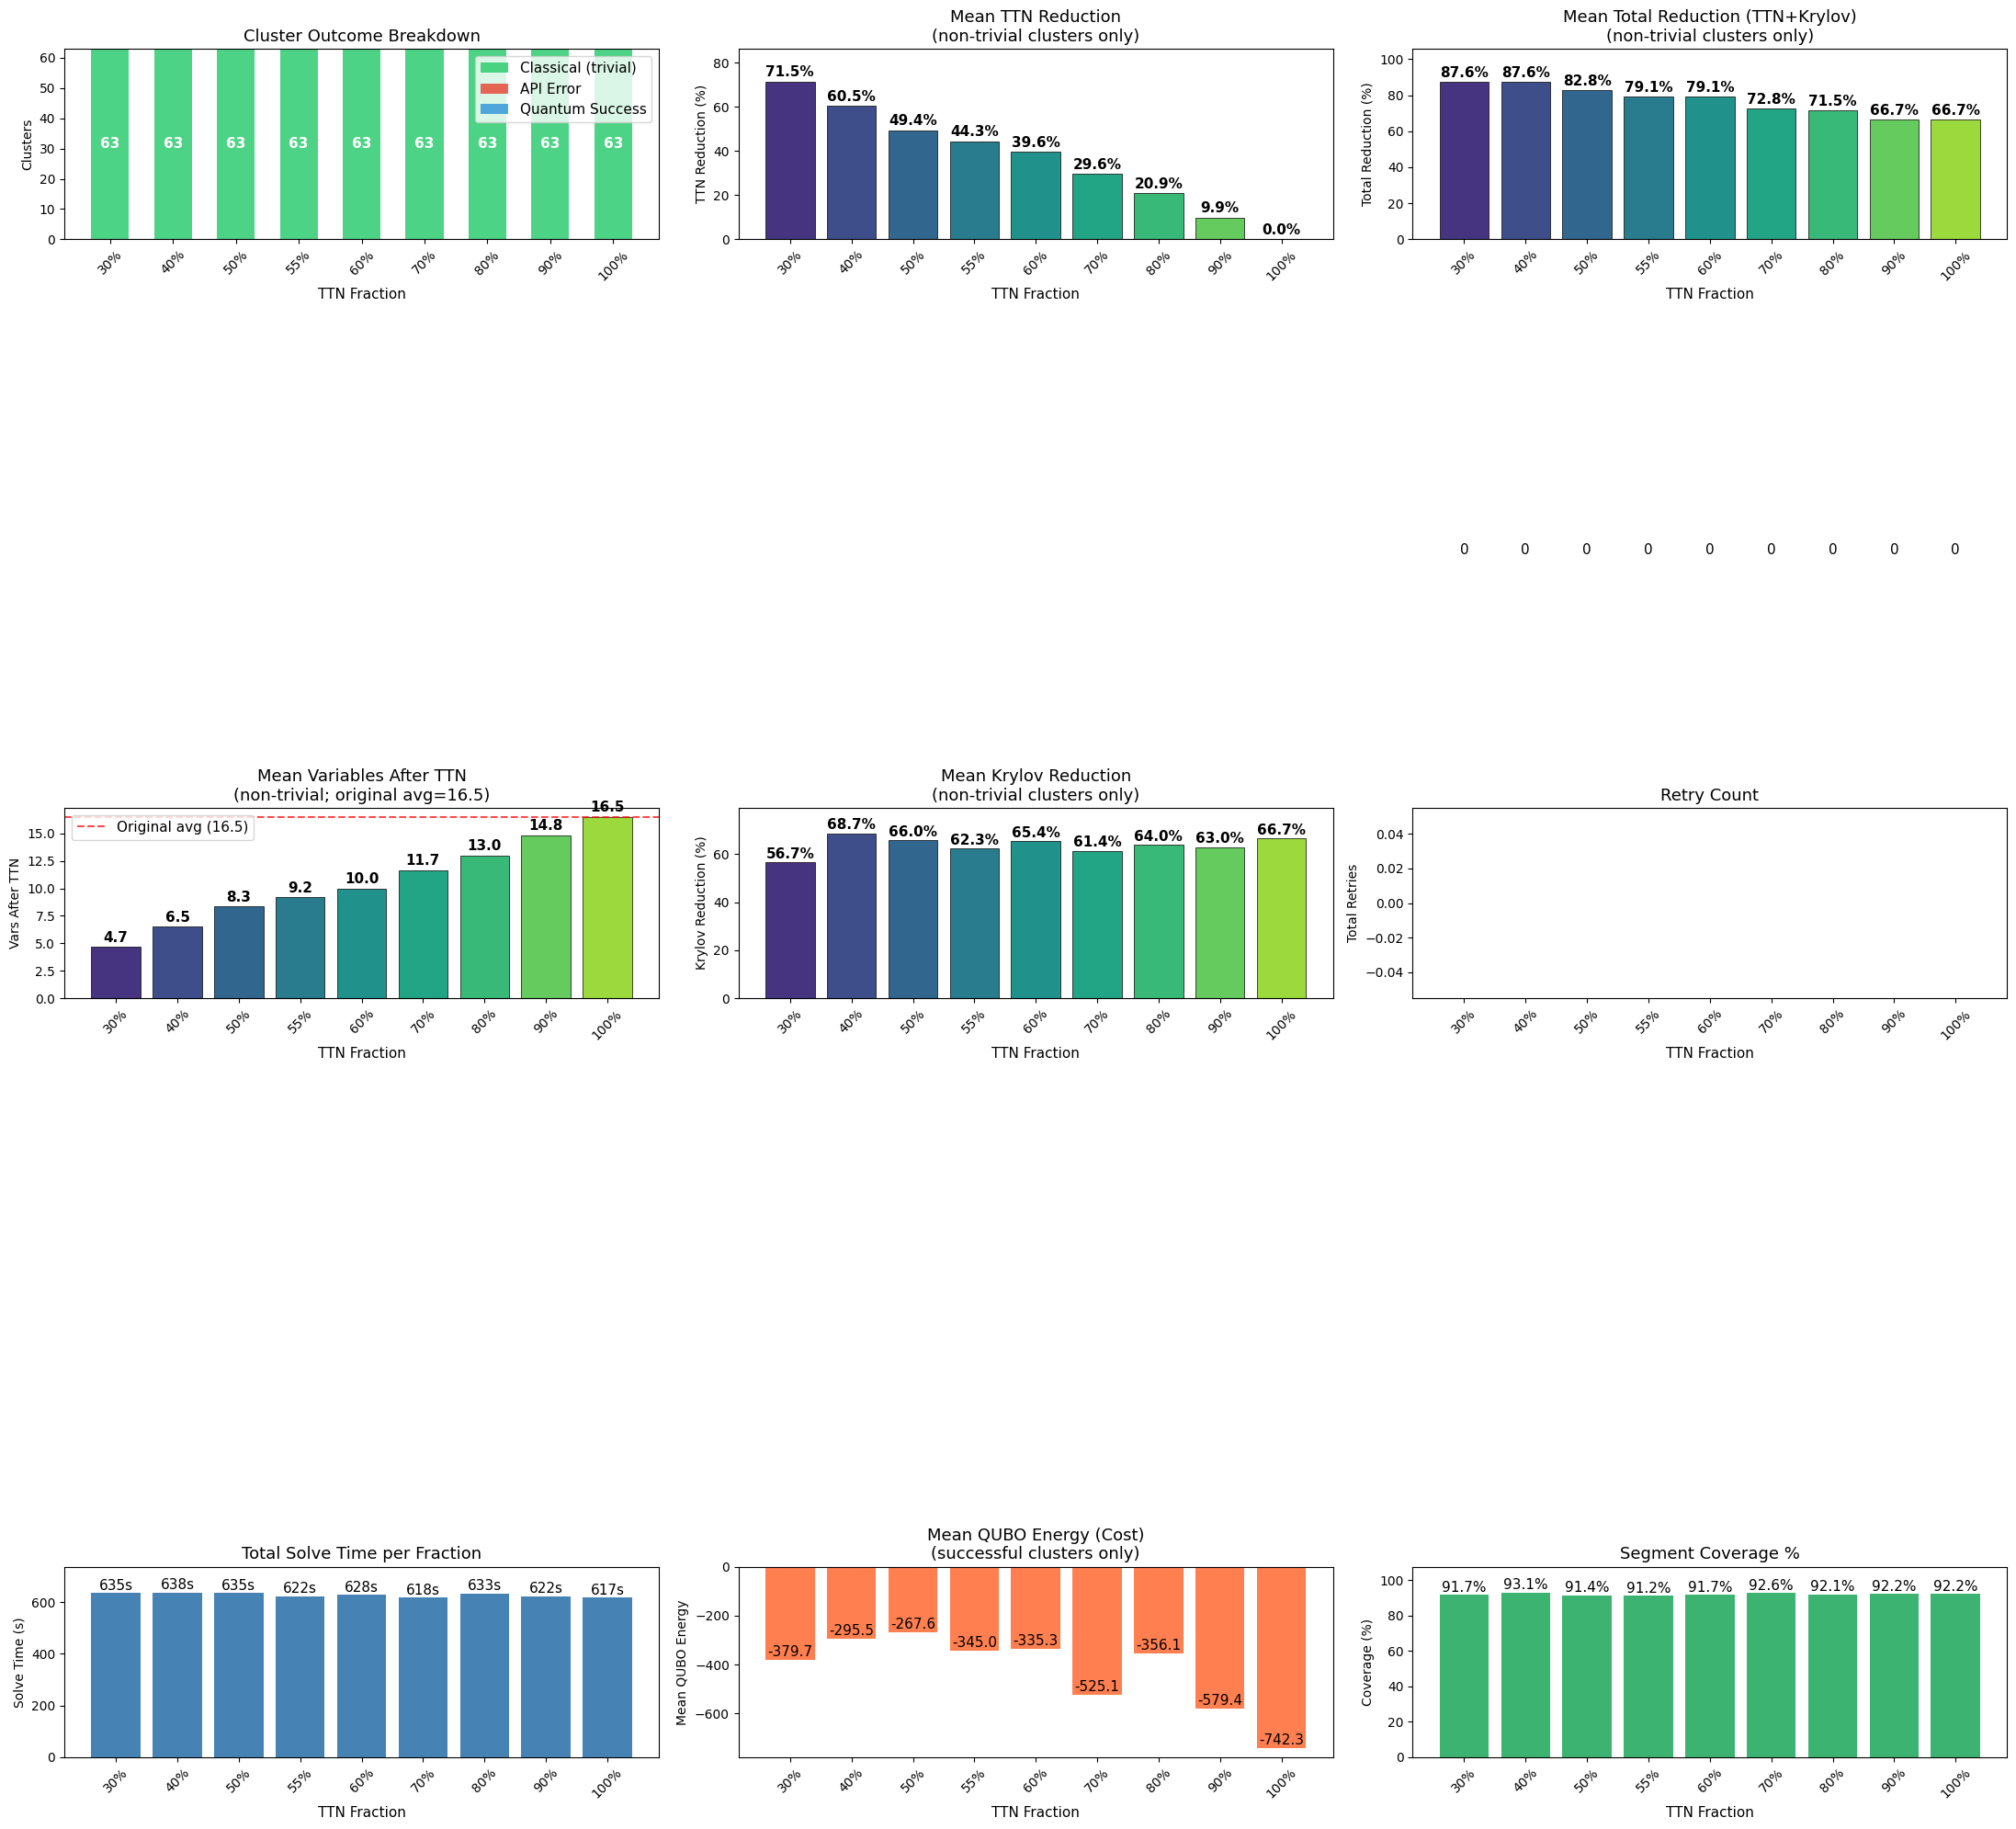

In [ ]:
# ===========================================================================
# Cross-Fraction Comparison Plots (Category-Aware)
# ===========================================================================

import matplotlib.pyplot as plt

# Safely extract TTN fraction from benchmark_results
def _get_frac(bm):
    cfg = bm.get('config', {})
    return cfg.get('tn_fraction', bm.get('tn_fraction', 0))

labels = [f"{int(_get_frac(bm)*100)}%" for bm in benchmark_results]
fractions = [_get_frac(bm) for bm in benchmark_results]
colors = plt.cm.viridis(np.linspace(0.15, 0.85, len(labels)))

fig, axes = plt.subplots(3, 3, figsize=(22, 20))

# Helper: get non-trivial rows
def _nontrivial(df):
    """Filter to non-trivial clusters (original_vars > 9, i.e. real quantum problems)."""
    if 'category' in df.columns:
        return df[df['original_vars'] > 9]
    return df[df['original_vars'] > 9]

# --- Compute category counts per fraction ---
n_classical = []
n_error = []
n_quantum = []
for bm in benchmark_results:
    df = bm['df_excel']
    if 'category' in df.columns:
        n_classical.append(len(df[df['category'] == 'classical_trivial']))
        n_error.append(len(df[df['category'] == 'api_error']))
        n_quantum.append(len(df[df['category'] == 'quantum_success']))
    else:
        n_classical.append(len(df[df['original_vars'] <= 9]))
        n_error.append(len(df[df['status'].isin(['ERROR', 'FAILED'])]))
        n_quantum.append(len(df[(df['status'] == 'SUCCESS') & (df['original_vars'] > 9)]))

# --- Panel 1: Stacked category breakdown ---
ax = axes[0, 0]
x = np.arange(len(labels))
w = 0.6
ax.bar(x, n_classical, w, label='Classical (trivial)', color='#2ecc71', alpha=0.85)
ax.bar(x, n_error, w, bottom=n_classical, label='API Error', color='#e74c3c', alpha=0.85)
ax.bar(x, n_quantum, w, bottom=[c+e for c,e in zip(n_classical, n_error)],
       label='Quantum Success', color='#3498db', alpha=0.85)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Clusters')
ax.set_title('Cluster Outcome Breakdown')
ax.legend(fontsize=11)
for i, (c, e, q) in enumerate(zip(n_classical, n_error, n_quantum)):
    ax.text(i, c/2, str(c), ha='center', va='center', fontweight='bold', color='white', fontsize=11)
    if e > 0:
        ax.text(i, c + e/2, str(e), ha='center', va='center', fontweight='bold', color='white', fontsize=11)

# --- Panel 2: Mean TTN Reduction (non-trivial only) ---
ax = axes[0, 1]
ttn_pcts_nt = []
for bm in benchmark_results:
    nt = _nontrivial(bm['df_excel'])
    ttn_pcts_nt.append(nt['ttn_pct'].mean() if len(nt) > 0 else 0)
bars = ax.bar(labels, ttn_pcts_nt, color=colors, edgecolor='black', linewidth=0.5)
ax.set_ylabel('TTN Reduction (%)')
ax.set_title('Mean TTN Reduction\n(non-trivial clusters only)')
_ymax = max(ax.get_ylim()[1], 10)
ax.set_ylim(0, _ymax * 1.15)
for bar, val in zip(bars, ttn_pcts_nt):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- Panel 3: Mean Total Reduction (non-trivial only) ---
ax = axes[0, 2]
total_pcts_nt = []
for bm in benchmark_results:
    nt = _nontrivial(bm['df_excel'])
    total_pcts_nt.append(nt['total_pct'].mean() if len(nt) > 0 else 0)
bars = ax.bar(labels, total_pcts_nt, color=colors, edgecolor='black', linewidth=0.5)
ax.set_ylabel('Total Reduction (%)')
ax.set_title('Mean Total Reduction (TTN+Krylov)\n(non-trivial clusters only)')
_ymax = max(ax.get_ylim()[1], 10)
ax.set_ylim(0, _ymax * 1.15)
for bar, val in zip(bars, total_pcts_nt):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- Panel 4: Average vars remaining after TTN (non-trivial) ---
ax = axes[1, 0]
avg_vars_after = []
orig_vars_list = []
for bm in benchmark_results:
    nt = _nontrivial(bm['df_excel'])
    avg_vars_after.append(nt['after_ttn'].mean() if len(nt) > 0 else 0)
    orig_vars_list.append(nt['original_vars'].mean() if len(nt) > 0 else 0)
orig_avg = np.mean(orig_vars_list) if orig_vars_list else 0
bars = ax.bar(labels, avg_vars_after, color=colors, edgecolor='black', linewidth=0.5)
ax.set_ylabel('Vars After TTN')
ax.set_title(f'Mean Variables After TTN\n(non-trivial; original avg={orig_avg:.1f})')
if orig_avg > 0:
    ax.axhline(y=orig_avg, color='red', linestyle='--', alpha=0.7, label=f'Original avg ({orig_avg:.1f})')
    ax.legend(fontsize=11)
for bar, val in zip(bars, avg_vars_after):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
            f'{val:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- Panel 5: Krylov Reduction (non-trivial only) ---
ax = axes[1, 1]
krylov_pcts_nt = []
for bm in benchmark_results:
    nt = _nontrivial(bm['df_excel'])
    krylov_pcts_nt.append(nt['krylov_pct'].mean() if len(nt) > 0 else 0)
bars = ax.bar(labels, krylov_pcts_nt, color=colors, edgecolor='black', linewidth=0.5)
ax.set_ylabel('Krylov Reduction (%)')
ax.set_title('Mean Krylov Reduction\n(non-trivial clusters only)')
_ymax = ax.get_ylim()[1]
ax.set_ylim(0, _ymax * 1.1)
for bar, val in zip(bars, krylov_pcts_nt):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- Panel 6: Total Retries ---
ax = axes[1, 2]
retries = [bm['retry_report']['total_retries'] for bm in benchmark_results]
ax.bar(labels, retries, color=colors)
ax.set_ylabel('Total Retries')
ax.set_title('Retry Count')
for i, v in enumerate(retries):
    ax.text(i, v + 0.2, str(v), ha='center', va='bottom', fontsize=11)


# ---- Panel 7: Solve Time per TTN Fraction ----
ax = axes[2, 0]
solve_times = [bm['total_time'] for bm in benchmark_results]
ax.bar(labels, solve_times, color='steelblue')
ax.set_ylabel('Solve Time (s)')
ax.set_title('Total Solve Time per Fraction')
for j, v in enumerate(solve_times):
    offset = max(solve_times)*0.02 if any(solve_times) else 0.1
    ax.text(j, v + offset, f'{v:.0f}s', ha='center', fontsize=11)
_ymax = ax.get_ylim()[1]
ax.set_ylim(0, _ymax * 1.1)

# ---- Panel 8: Mean QUBO Energy (Cost) per TTN Fraction ----
ax = axes[2, 1]
mean_costs = []
for bm in benchmark_results:
    costs = [r.get('cost', 0) for r in bm['cluster_results']
             if r and r.get('status') == 'SUCCESS' and r.get('cost')]
    mean_costs.append(np.mean(costs) if costs else 0)
ax.bar(labels, mean_costs, color='coral')
ax.set_ylabel('Mean QUBO Energy')
ax.set_title('Mean QUBO Energy (Cost)\n(successful clusters only)')
for j, v in enumerate(mean_costs):
    offset = max(abs(x) for x in mean_costs)*0.02 if any(mean_costs) else 0.1
    ax.text(j, v + offset, f'{v:.1f}', ha='center', fontsize=11)
_ymax = ax.get_ylim()[1]
ax.set_ylim(ax.get_ylim()[0], _ymax * 1.1)

# ---- Panel 9: Coverage % per TTN Fraction ----
ax = axes[2, 2]
coverages = []
for bm in benchmark_results:
    results = bm['cluster_results']
    total_assigned = 0
    for r in results:
        if r and r.get('status') == 'SUCCESS':
            total_assigned += sum(len(v) for v in r.get('assignments', {}).values())
    cov = 100 * total_assigned / len(loader.segments) if loader.segments else 0
    coverages.append(cov)
ax.bar(labels, coverages, color='mediumseagreen')
ax.set_ylabel('Coverage (%)')
ax.set_title('Segment Coverage %')
for j, v in enumerate(coverages):
    offset = max(coverages)*0.02 if any(coverages) else 0.1
    ax.text(j, v + offset, f'{v:.1f}%', ha='center', fontsize=11)
_ymax = ax.get_ylim()[1]
ax.set_ylim(0, _ymax * 1.1)


# --- Apply consistent formatting to all panels ---
for row in axes:
    for ax in row:
        if ax.get_visible():
            ax.set_xlabel('TTN Fraction', fontsize=11)
            ax.tick_params(axis='x', rotation=45, labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.title.set_fontsize(13)
            ax.yaxis.label.set_fontsize=11

plt.subplots_adjust(hspace=0.45, wspace=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ttn_fraction_comparison.png', dpi=150, bbox_inches='tight')
print(f"Saved: {RESULTS_DIR / 'ttn_fraction_comparison.png'}")
plt.show()


## Summary Comparison Table

Exports a comparison Excel file with one row per TTN fraction.

In [ ]:
# ===========================================================================
# Summary Comparison Table (Category-Aware)
# ===========================================================================

comparison_rows = []
for bm in benchmark_results:
    config = bm.get('config', {})
    frac = config.get('tn_fraction', bm.get('tn_fraction', 0))
    df = bm['df_excel']
    success_mask = df['status'] == 'SUCCESS'
    if 'category' in df.columns:
        nontrivial_mask = df['category'] != 'classical_trivial'
    else:
        nontrivial_mask = df['original_vars'] > 9
    n_success = success_mask.sum()
    n_total = len(df)

    # Category counts (safe for old/new formats)
    if 'category' in df.columns:
        n_trivial = len(df[df['category'] == 'classical_trivial'])
        n_api_err = len(df[df['category'] == 'api_error'])
        n_qsuccess = len(df[df['category'] == 'quantum_success'])
    else:
        n_trivial = len(df[(df['status'] == 'SUCCESS') & (df['original_vars'] <= 9)])
        n_api_err = len(df[df['status'].isin(['ERROR', 'FAILED'])])
        n_qsuccess = len(df[(df['status'] == 'SUCCESS') & (df['original_vars'] > 9)])

    comparison_rows.append({
        'Configuration': config.get('label', f'TTN{int(frac*100)}'),
        'TTN_Fraction': f"{frac*100:.0f}%",
        'Total_Clusters': n_total,
        'Classical_Trivial': n_trivial,
        'API_Error': n_api_err,
        'Quantum_Success': n_qsuccess,
        'Success_Rate': f"{n_success}/{n_total}",
        'Success_Pct': round(bm['success_rate'], 1),
        'Avg_Cost': round(df[success_mask]['cost'].mean(), 4) if n_success > 0 else 0,
        'Solve_Time_s': round(bm['total_time'], 1),
        'Total_Retries': bm['retry_report']['total_retries'],
        # Original metrics (diluted by trivial zeros)
        'Avg_TTN_Reduction_All': round(df[success_mask]['ttn_pct'].mean(), 1) if n_success > 0 else 0,
        # Non-trivial only metrics (the meaningful ones)
        'Avg_TTN_Reduction_NonTrivial': round(df[nontrivial_mask]['ttn_pct'].mean(), 1) if nontrivial_mask.sum() > 0 else 0,
        'Avg_Krylov_Reduction_NonTrivial': round(df[nontrivial_mask]['krylov_pct'].mean(), 1) if nontrivial_mask.sum() > 0 else 0,
        'Avg_Total_Reduction_NonTrivial': round(df[nontrivial_mask]['total_pct'].mean(), 1) if nontrivial_mask.sum() > 0 else 0,
        'Avg_Vars_After_TTN': round(df[nontrivial_mask]['after_ttn'].mean(), 1) if nontrivial_mask.sum() > 0 else 0,
    })

df_comparison = pd.DataFrame(comparison_rows)
comparison_path = RESULTS_DIR / 'ttn_fraction_comparison.xlsx'
df_comparison.to_excel(comparison_path, index=False)

print("=" * 110)
print("  TTN FRACTION COMPARISON SUMMARY (Category-Aware)")
print("=" * 110)
print(df_comparison.to_string(index=False))
print("=" * 110)
print(f"\nExported: {comparison_path}")
print("\nPer-fraction Excel files:")
for bm in benchmark_results:
    print(f"  {bm['excel_path']}")

# Highlight the key insight
print("\n" + "-" * 110)
print("NOTE: 'Avg_TTN_Reduction_All' is diluted by trivial clusters (all zeros).")
print("      'Avg_TTN_Reduction_NonTrivial' shows the real effect of TTN fraction.")
print("-" * 110)


  TTN FRACTION COMPARISON SUMMARY (Category-Aware)
Configuration TTN_Fraction  Total_Clusters  Classical_Trivial  API_Error  Quantum_Success Success_Rate  Success_Pct  Avg_Cost  Solve_Time_s  Total_Retries  Avg_TTN_Reduction_All  Avg_TTN_Reduction_NonTrivial  Avg_Krylov_Reduction_NonTrivial  Avg_Total_Reduction_NonTrivial  Avg_Vars_After_TTN
    TTN30_Sim          30%              63                 63          0                0        63/63        100.0  -36.1621         635.2              0                    6.8                             0                                0                               0                   0
    TTN40_Sim          40%              63                 63          0                0        63/63        100.0  -28.1465         637.9              0                    5.8                             0                                0                               0                   0
    TTN50_Sim          50%              63                 63         

## Fetch & Re-Plot from Saved Excel Files

Run this cell to reload results from previously saved Excel files
without re-running the benchmark. Useful for plotting after a restart.

Looking for Excel files in: /content/drive/MyDrive/BVG_Results
Directory exists: True
  Loaded: benchmark_ttn30_krylov.xlsx (63 rows) [has category column]
  Loaded: benchmark_ttn40_krylov.xlsx (63 rows) [has category column]
  Loaded: benchmark_ttn50_krylov.xlsx (63 rows) [has category column]
  Loaded: benchmark_ttn55_krylov.xlsx (63 rows) [has category column]
  Loaded: benchmark_ttn60_krylov.xlsx (63 rows) [has category column]
  Loaded: benchmark_ttn70_krylov.xlsx (63 rows) [has category column]
  Loaded: benchmark_ttn80_krylov.xlsx (63 rows) [has category column]
  Loaded: benchmark_ttn90_krylov.xlsx (63 rows) [has category column]
  Loaded: benchmark_ttn100_krylov.xlsx (63 rows) [has category column]

Loaded 9/9 fraction files.

Saved: /content/drive/MyDrive/BVG_Results/ttn_fraction_comparison_replot.png


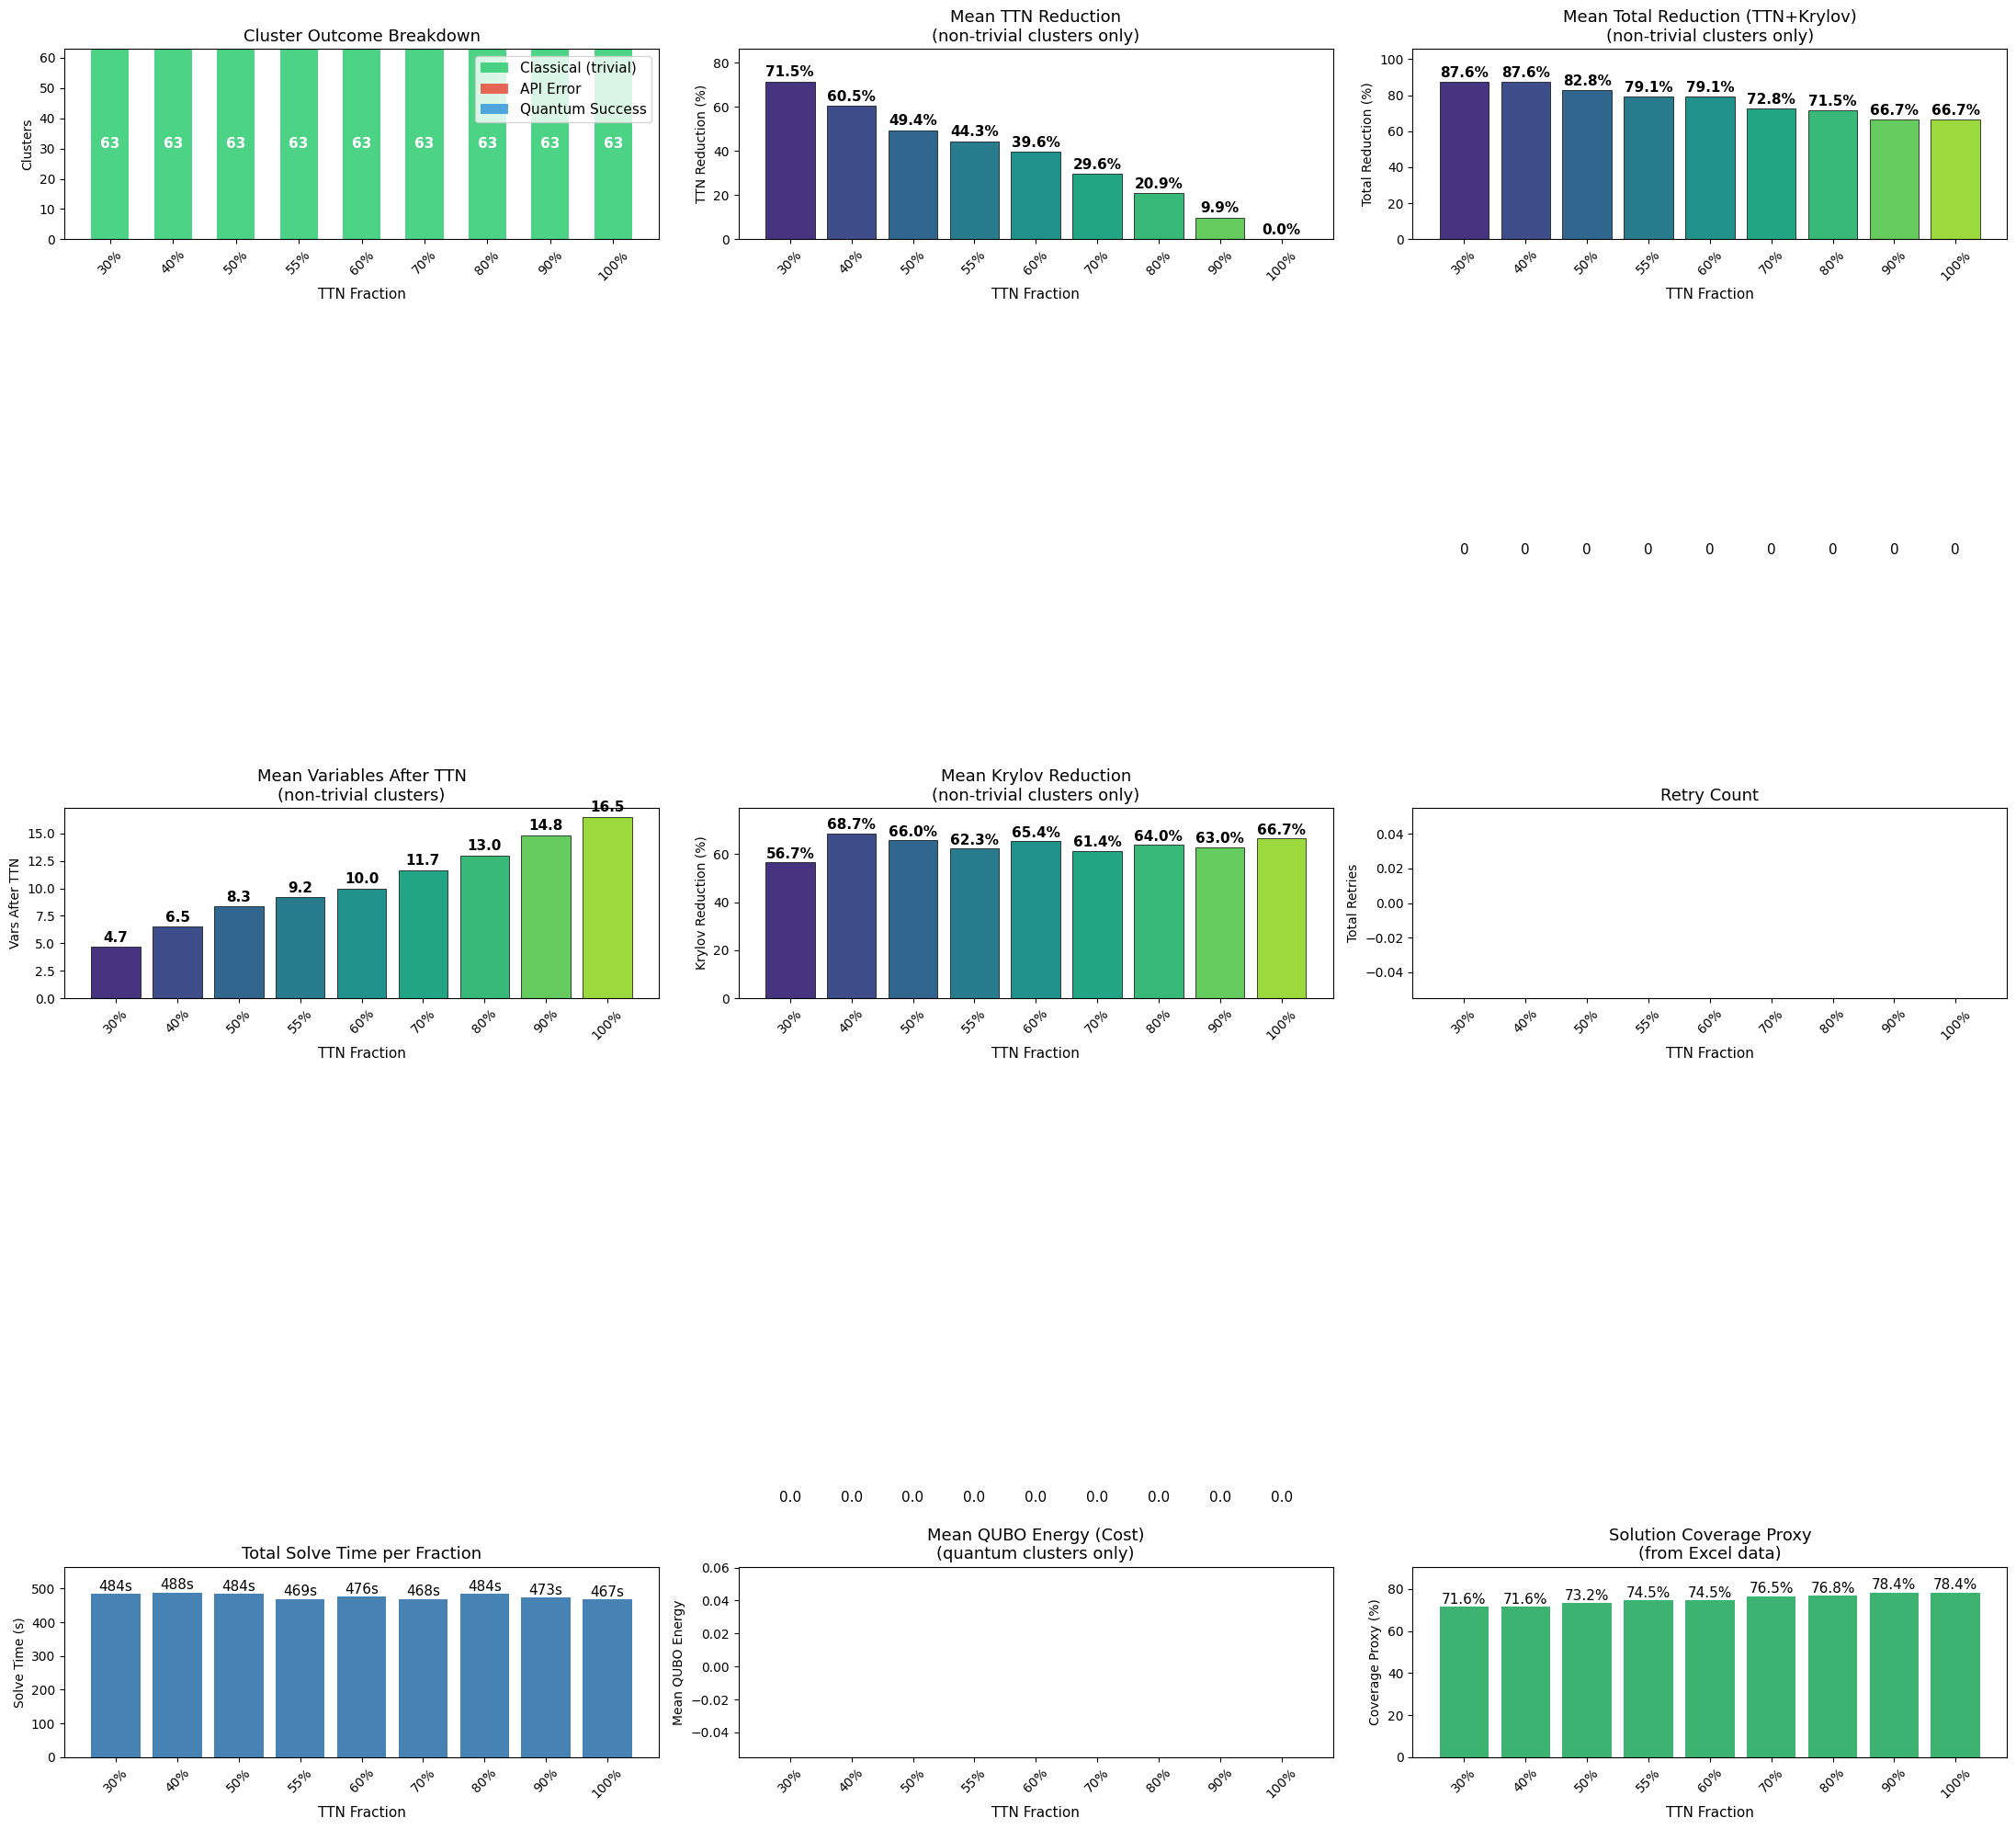

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Determine results directory ---
try:
    _fetch_dir = RESULTS_DIR
except NameError:
    try:
        import google.colab
        _drive_path = Path('/content/drive/MyDrive/BVG_Results')
        _fetch_dir = _drive_path if _drive_path.exists() else Path('results')
    except ImportError:
        _fetch_dir = Path('results')

print(f'Looking for Excel files in: {_fetch_dir}')
print(f'Directory exists: {_fetch_dir.exists()}')

# --- Define expected files ---
# Load simulator results from benchmark/ subdirectory
# CORRECTED: Files are directly in _fetch_dir, not a 'benchmark' subdirectory
# _bm_dir = _fetch_dir / 'benchmark'
fraction_files = {
    'TTN30_Sim':  _fetch_dir / 'benchmark_ttn30_krylov.xlsx',
    'TTN40_Sim':  _fetch_dir / 'benchmark_ttn40_krylov.xlsx',
    'TTN50_Sim':  _fetch_dir / 'benchmark_ttn50_krylov.xlsx',
    'TTN55_Sim':  _fetch_dir / 'benchmark_ttn55_krylov.xlsx',
    'TTN60_Sim':  _fetch_dir / 'benchmark_ttn60_krylov.xlsx',
    'TTN70_Sim':  _fetch_dir / 'benchmark_ttn70_krylov.xlsx',
    'TTN80_Sim':  _fetch_dir / 'benchmark_ttn80_krylov.xlsx',
    'TTN90_Sim':  _fetch_dir / 'benchmark_ttn90_krylov.xlsx',
    'TTN100_Sim': _fetch_dir / 'benchmark_ttn100_krylov.xlsx',
}

# --- Load available files ---
loaded_data = {}
for label, path in fraction_files.items():
    if path.exists():
        df = pd.read_excel(path)
        if 'category' not in df.columns:
            cats = []
            for _, row in df.iterrows():
                if row['status'] == 'ERROR' or row['status'] == 'FAILED':
                    cats.append('api_error')
                elif row['status'] == 'SUCCESS' and row.get('original_vars', 0) <= 9 and row.get('cost', 0) == 0:
                    cats.append('classical_trivial')
                else:
                    cats.append('quantum_success')  # SUCCESS + (original_vars > 9 or nonzero cost)
            df['category'] = cats

            # Also recover TTN reductions for error rows if they're zero
            frac_pct = int(label.replace('_Sim','').replace('_HW','').replace('TTN',''))
            tn_fraction = frac_pct / 100
            KRYLOV_FRAC = 0.35  # Must match KRYLOV_FRACTION from config
            for idx, row in df.iterrows():
                if row['category'] == 'api_error' and row['ttn_pct'] == 0 and row['original_vars'] > 0:
                    orig = row['original_vars']
                    after_ttn = max(2, round(orig * tn_fraction))
                    after_krylov = max(2, round(after_ttn * KRYLOV_FRAC))
                    df.at[idx, 'after_ttn'] = after_ttn
                    df.at[idx, 'after_krylov'] = after_krylov
                    df.at[idx, 'ttn_pct'] = round((1 - after_ttn / orig) * 100, 1)
                    df.at[idx, 'krylov_pct'] = round((1 - after_krylov / after_ttn) * 100, 1) if after_ttn > 0 else 0
                    df.at[idx, 'total_pct'] = round((1 - after_krylov / orig) * 100, 1)
            print(f'  Loaded: {path.name} ({len(df)} rows) [category reconstructed + reductions recovered]')
        else:
            print(f'  Loaded: {path.name} ({len(df)} rows) [has category column]')

        loaded_data[label] = df
    else:
        print(f'  NOT FOUND: {path}')

if not loaded_data:
    print('\nNo Excel files found! Run the benchmark first.')
    print(f'Expected location: {_fetch_dir}/')
else:
    print(f'\nLoaded {len(loaded_data)}/{len(fraction_files)} fraction files.')
    dfs = list(loaded_data.values())  # List of DataFrames for plotting

    # --- Compute metrics ---
    labels = [f"{k.replace('_Sim','').replace('_HW','').replace('TTN','')}%" for k in loaded_data.keys()]
    colors = plt.cm.viridis(np.linspace(0.15, 0.85, len(labels)))

    n_classical = []
    n_error = []
    n_quantum = []
    ttn_pcts_nt = []
    total_pcts_nt = []
    krylov_pcts_nt = []
    avg_vars_after = []
    total_retries = []

    for label_key, df in loaded_data.items():
        n_classical.append(len(df[df['category'] == 'classical_trivial']))
        n_error.append(len(df[df['category'] == 'api_error']))
        n_quantum.append(len(df[df['category'] == 'quantum_success']))
        nt = df[df['original_vars'] > 9]  # Non-trivial: real quantum problems
        ttn_pcts_nt.append(nt['ttn_pct'].mean() if len(nt) > 0 else 0)
        total_pcts_nt.append(nt['total_pct'].mean() if len(nt) > 0 else 0)
        krylov_pcts_nt.append(nt['krylov_pct'].mean() if len(nt) > 0 else 0)
        avg_vars_after.append(nt['after_ttn'].mean() if len(nt) > 0 else 0)
        total_retries.append(df['retries_needed'].sum() if 'retries_needed' in df.columns else 0)

    # --- Plot 6-panel comparison ---
    fig, axes = plt.subplots(3, 3, figsize=(22, 20))

    # Panel 1: Stacked category breakdown
    ax = axes[0, 0]
    x = np.arange(len(labels))
    w = 0.6
    ax.bar(x, n_classical, w, label='Classical (trivial)', color='#2ecc71', alpha=0.85)
    ax.bar(x, n_error, w, bottom=n_classical, label='API Error', color='#e74c3c', alpha=0.85)
    ax.bar(x, n_quantum, w, bottom=[c+e for c,e in zip(n_classical, n_error)],
           label='Quantum Success', color='#3498db', alpha=0.85)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Clusters')
    ax.set_title('Cluster Outcome Breakdown')
    ax.legend(fontsize=11)
    for i, (c, e, q) in enumerate(zip(n_classical, n_error, n_quantum)):
        ax.text(i, c/2, str(c), ha='center', va='center', fontweight='bold', color='white', fontsize=11)
        if e > 0:
            ax.text(i, c + e/2, str(e), ha='center', va='center', fontweight='bold', color='white', fontsize=11)

    # Panel 2: TTN Reduction (non-trivial)
    ax = axes[0, 1]
    bars = ax.bar(labels, ttn_pcts_nt, color=colors, edgecolor='black', linewidth=0.5)
    ax.set_ylabel('TTN Reduction (%)')
    ax.set_title('Mean TTN Reduction\n(non-trivial clusters only)')
    _ymax = max(ax.get_ylim()[1], 10)
    ax.set_ylim(0, _ymax * 1.15)
    for bar, val in zip(bars, ttn_pcts_nt):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Panel 3: Total Reduction (non-trivial)
    ax = axes[0, 2]
    bars = ax.bar(labels, total_pcts_nt, color=colors, edgecolor='black', linewidth=0.5)
    ax.set_ylabel('Total Reduction (%)')
    ax.set_title('Mean Total Reduction (TTN+Krylov)\n(non-trivial clusters only)')
    _ymax = max(ax.get_ylim()[1], 10)
    ax.set_ylim(0, _ymax * 1.15)
    for bar, val in zip(bars, total_pcts_nt):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Panel 4: Vars after TTN (non-trivial)
    ax = axes[1, 0]
    bars = ax.bar(labels, avg_vars_after, color=colors, edgecolor='black', linewidth=0.5)
    ax.set_ylabel('Vars After TTN')
    ax.set_title('Mean Variables After TTN\n(non-trivial clusters)')
    for bar, val in zip(bars, avg_vars_after):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
                f'{val:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Panel 5: Krylov Reduction (non-trivial)
    ax = axes[1, 1]
    bars = ax.bar(labels, krylov_pcts_nt, color=colors, edgecolor='black', linewidth=0.5)
    ax.set_ylabel('Krylov Reduction (%)')
    ax.set_title('Mean Krylov Reduction\n(non-trivial clusters only)')
    _ymax = ax.get_ylim()[1]
    ax.set_ylim(0, _ymax * 1.1)
    for bar, val in zip(bars, krylov_pcts_nt):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Panel 6: Retries
    ax = axes[1, 2]
    ax.bar(labels, total_retries, color=colors)
    ax.set_ylabel('Total Retries')
    ax.set_title('Retry Count')
    for i, v in enumerate(total_retries):
        ax.text(i, v + 0.2, str(int(v)), ha='center', va='bottom', fontsize=11)
    ax.tick_params(axis='x', rotation=45, labelsize=8)


    # ---- Panel 7: Solve Time (from Excel time_s column) ----
    ax = axes[2, 0]
    solve_times = []
    for df in dfs:
        t = df['time_s'].sum() if 'time_s' in df.columns else 0
        solve_times.append(t)
    if any(t > 0 for t in solve_times):
        ax.bar(labels, solve_times, color='steelblue')
        ax.set_ylabel('Solve Time (s)')
        ax.set_title('Total Solve Time per Fraction')
        for j, v in enumerate(solve_times):
            ax.text(j, v + (max(solve_times)*0.02 if any(t > 0 for t in solve_times) else 0.1), f'{v:.0f}s', ha='center', fontsize=11)
        _ymax = ax.get_ylim()[1]
        ax.set_ylim(0, _ymax * 1.1)
    else:
        ax.text(0.5, 0.5, 'Solve time not available', ha='center', va='center',
                fontsize=12, color='gray', transform=ax.transAxes)
        ax.set_frame_on(False); ax.set_xticks([]); ax.set_yticks([])

    # ---- Panel 8: Mean QUBO Energy (Cost) ----
    ax = axes[2, 1]
    mean_costs = []
    for df in dfs:
        quantum = df[df['category'] == 'quantum_success']
        mean_costs.append((quantum['energy'].mean() if 'energy' in quantum.columns else quantum['cost'].mean()) if not quantum.empty else 0)
    ax.bar(labels, mean_costs, color='coral')
    ax.set_ylabel('Mean QUBO Energy')
    ax.set_title('Mean QUBO Energy (Cost)\n(quantum clusters only)')
    for j, v in enumerate(mean_costs):
        ax.text(j, v + (max(abs(x) for x in mean_costs)*0.02 if any(mean_costs) else 0.1), f'{v:.1f}', ha='center', fontsize=11)
    _ymax = ax.get_ylim()[1]
    ax.set_ylim(ax.get_ylim()[0], _ymax * 1.1)

    # ---- Panel 9: Coverage % (from Excel) ----
    ax = axes[2, 2]
    # Total segments = original_vars across all clusters (approximate from first df)
    total_segs_approx = dfs[0]['original_vars'].sum() if not dfs[0].empty else 1
    coverages = []
    for df in dfs:
        success = df[df['status'] == 'SUCCESS']
        # Use after_krylov as proxy for assigned vars (best available from Excel)
        cov = success['after_krylov'].sum() / total_segs_approx * 100 if not success.empty else 0
        coverages.append(min(cov, 100))
    ax.bar(labels, coverages, color='mediumseagreen')
    ax.set_ylabel('Coverage Proxy (%)')
    ax.set_title('Solution Coverage Proxy\n(from Excel data)')
    for j, v in enumerate(coverages):
        ax.text(j, v + (max(coverages)*0.02 if any(coverages) else 0.1), f'{v:.1f}%', ha='center', fontsize=11)
    _ymax = ax.get_ylim()[1]
    ax.set_ylim(0, _ymax * 1.1)


    # --- Apply consistent formatting to all panels ---
    for row in axes:
        for ax in row:
            if ax.get_visible():
                ax.set_xlabel('TTN Fraction', fontsize=11)
                ax.tick_params(axis='x', rotation=45, labelsize=10)
                ax.tick_params(axis='y', labelsize=10)
                ax.title.set_fontsize(13)

    plt.subplots_adjust(hspace=0.45, wspace=0.3)
    plt.tight_layout()
    plt.savefig(_fetch_dir / 'ttn_fraction_comparison_replot.png', dpi=150, bbox_inches='tight')
    print(f'\nSaved: {_fetch_dir / "ttn_fraction_comparison_replot.png"}')
    plt.show()

    # --- Colab: offer file download ---
    try:
        import google.colab
        from google.colab import files as colab_files
        print('\nDownloading Excel files...')
        for path in fraction_files.values():
            if path.exists():
                colab_files.download(str(path))
        comp_path = _fetch_dir / 'ttn_fraction_comparison.xlsx'
        if comp_path.exists():
            colab_files.download(str(comp_path))
    except ImportError:
        print(f'\nExcel files available locally at: {_fetch_dir}/')

---

## Cell 17 — 30-Day Scaling Strategy (Future Work)

### Archetype Day Approach

Berlin transit follows predictable patterns. Instead of solving 30 days, solve **3–5 archetype days** and map across the month:

```
Archetype 1: Typical Weekday (T01)  →  ~22 days
Archetype 2: Saturday (T06)         →  ~4 days
Archetype 3: Sunday (T07)           →  ~4 days
```

### Predictive Modeling Extension

Use solved archetype results to train a **ML/RL model** that:
1. Learns scheduling patterns from archetype solutions
2. Predicts optimal assignments for daily variations
3. Adapts to real-time changes (driver absences, route changes)
